# Imports and Data

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
calls = {}
for c in ['uk', 'uk1', 'uk2', 'mit']:
    calls[c] = pc.apply_filters(unfiltered[c], 60)

globalt0 = dt.datetime.now()

# SI for PNAS

## Fig 1 with different values of $\Delta t_w$

Using the same lifetime groups as Fig 1 from the paper

In [2]:
10 in itlives[60].keys()

False

In [3]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

In [4]:
t0 = dt.datetime.now()
S1 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    S1[c] = {}
    if c == 'it':
        for Dt in itdffa15.keys():
            S1[c][Dt] = {}
            dff = itdffa15[Dt]
            for lamb in range(3):
                S1[c][Dt][lamb] = {'f': pc.get_avgfa(dff, itlives[Dt], limits[c][lamb][0], limits[c][lamb][1])}
    else:
        for Dt in itdffa15.keys():
            S1[c][Dt] = {}
            df = pc.apply_filters(unfiltered[c], Dt)
            for lamb in range(3):
                S1[c][Dt][lamb] = pc.get_fal(df, limits[c][lamb][0], limits[c][lamb][1], 15)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:07.017551


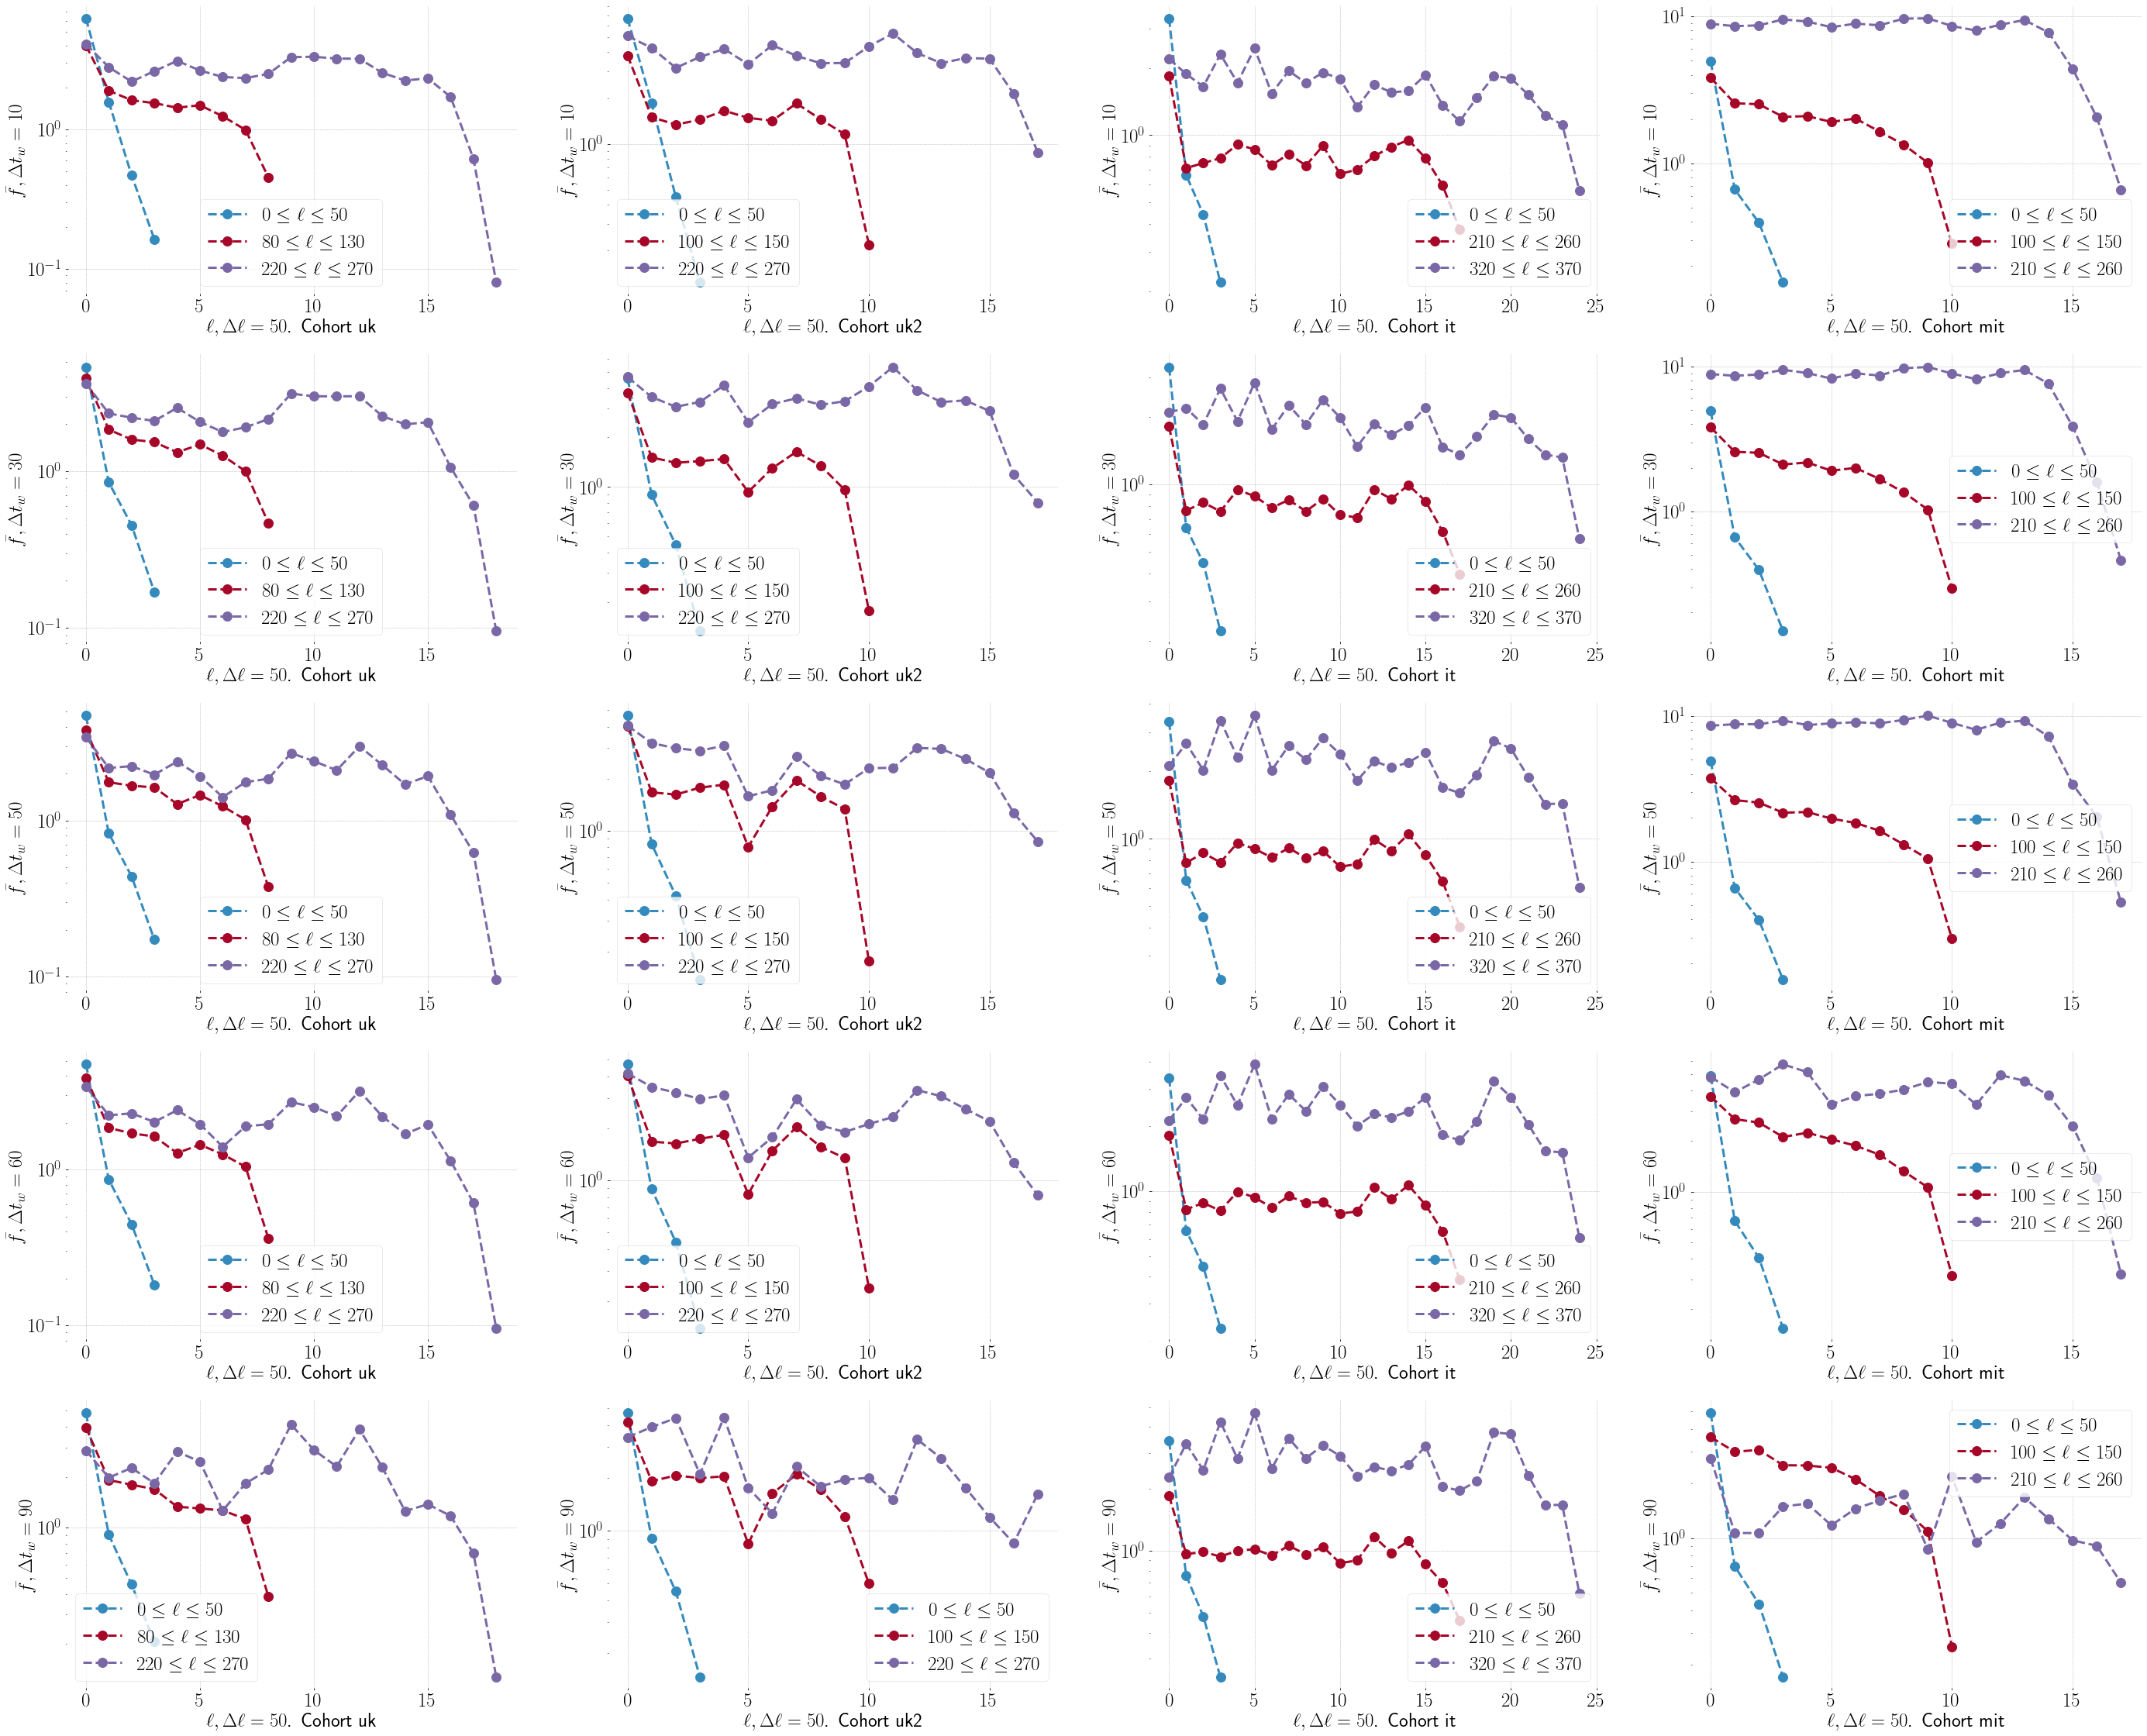

In [5]:
plt.figure(figsize=(12*4, 8*5))
p = 1
for Dt in S1['uk'].keys():
    for c in S1.keys():
        plt.subplot(5, 4, p)
        plt.xlabel(fr"$\ell, \Delta \ell = 50$. Cohort {c}")
        plt.ylabel(fr'$\bar{{f}}, \Delta t_w = {Dt}$')
        plt.semilogy()
        for lamb in range(3):
            plt.plot(S1[c][Dt][lamb]['f'].index, S1[c][Dt][lamb]['f']['f'], marker="o", markersize=12, ls="dashed", lw=3, label=fr'${limits[c][lamb][0]}\leq \ell \leq {limits[c][lamb][1]}$')
        plt.legend()
        p += 1

In [6]:
tmp = pd.DataFrame(index=list(range(25)))
for c in S1.keys():
    for Dt in S1[c].keys():
        for i in range(3):
            idx = list(S1[c][Dt][i]['f'].index)
            series = list(S1[c][Dt][i]['f']['f'])
            colname = f'{c}{Dt}{["s", "m", "l"][i]}'
            df = pd.DataFrame({colname: series}, index=idx)
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S1.dat", header=True, index=True, sep="\t")

In [7]:
S1['uk'].keys()

dict_keys([10, 30, 50, 60, 90])

## S2: Fig 1 with different values for $\Delta \ell$

In [8]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

In [9]:
lims = {}
for c in limits.keys():
    lims[c] = {}
    for i in range(3):
        lims[c][i] = [limits[c][i]] + [(limits[c][i][0], limits[c][i][0] + Dl) for Dl in [10, 30, 70, 90]]

In [10]:
S2 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    S2[c] = {}
    for i in range(3):
        S2[c][i] = {}
        for j in range(5):
            if c == 'it':
                S2[c][i][j] = {'f': pc.get_avgfa(itdffa15[60], itlives[60], lims[c][i][j][0], lims[c][i][j][1])}
            else:
                S2[c][i][j] = pc.get_fal(calls[c], lims[c][i][j][0], lims[c][i][j][1], 15)

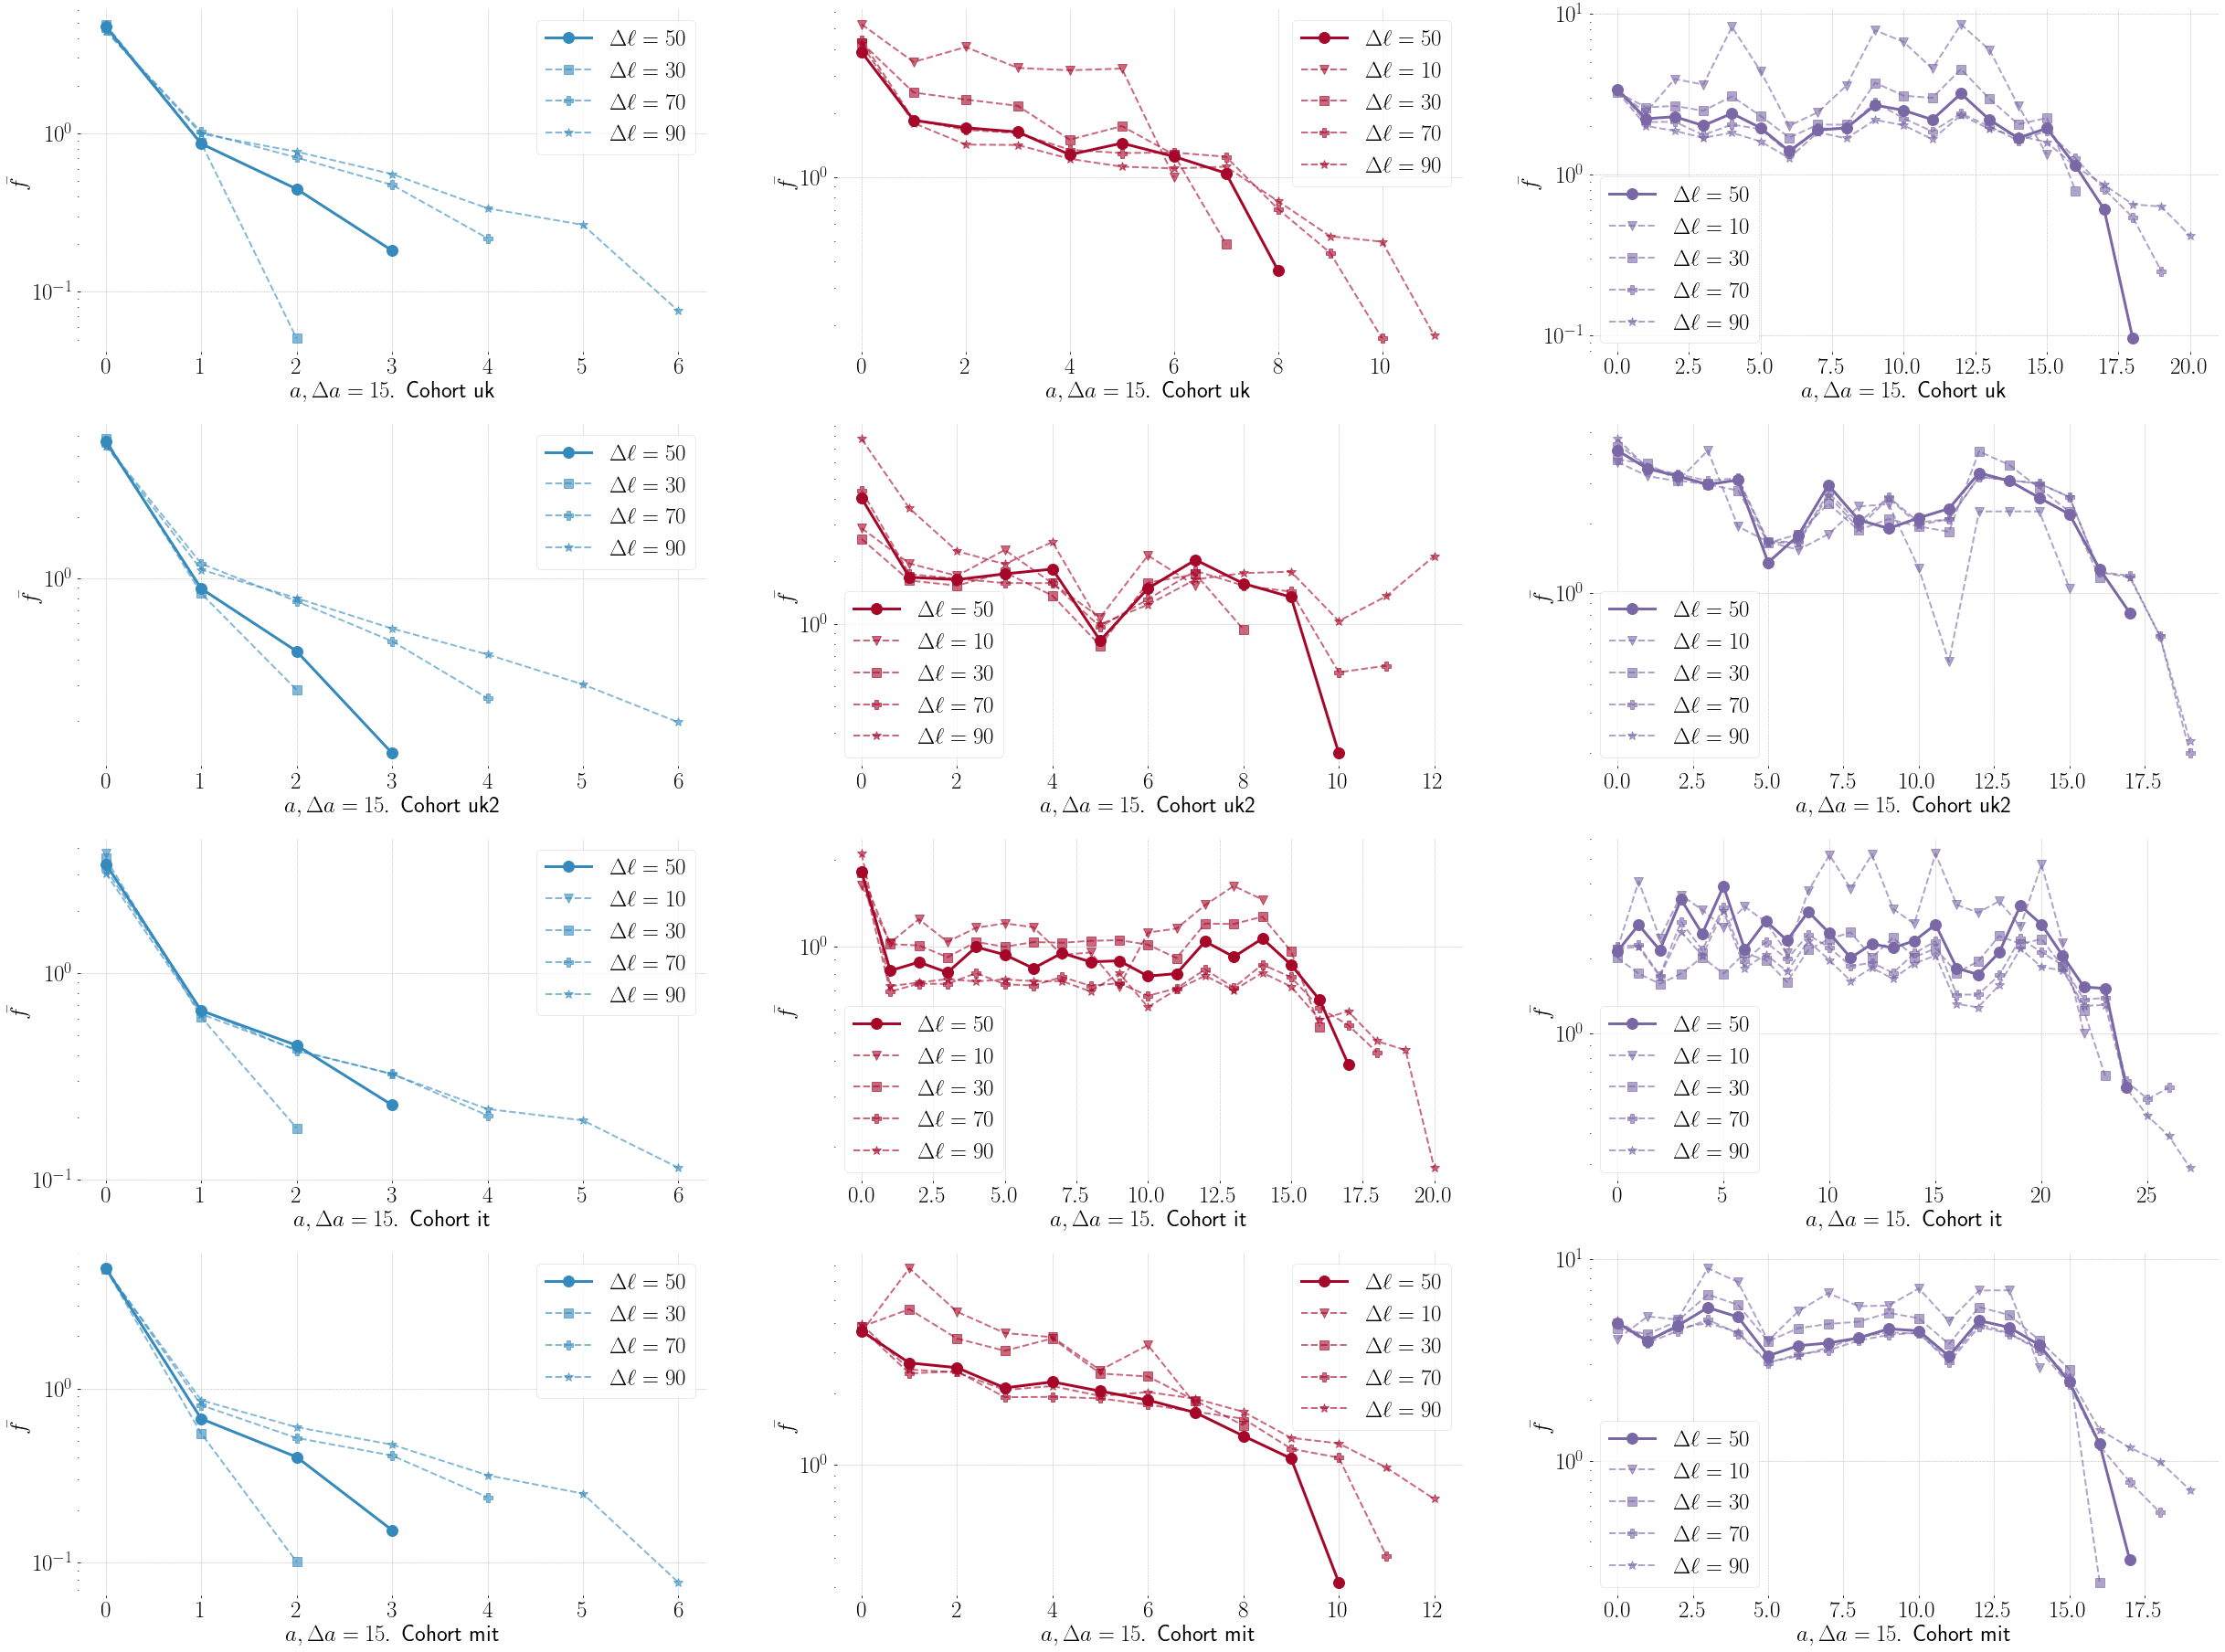

In [11]:
plt.figure(figsize=(14*3, 8*4))
p = 1
for c in S2.keys():
    for lg in S2[c].keys():
        plt.subplot(4, 3, p)
        plt.xlabel(fr"$a, \Delta a  = 15$. Cohort {c}")
        plt.ylabel(r"$\bar{f}$")
        plt.semilogy()
        plt.plot(S2[c][lg][0]['f'].index, S2[c][lg][0]['f']['f'], marker="o", markersize=12, ls="solid", lw=3, c=colors[lg], label=r'$\Delta \ell = 50$')
        for i in range(1, 5):
            if S2[c][lg][i] is not None:
                plt.plot(S2[c][lg][i]['f'].index, S2[c][lg][i]['f']['f'], marker=markers[i], markersize=10, ls="dashed", lw=2, c=colors[lg], alpha=0.6, label=fr'$\Delta \ell = {[10, 30, 70, 90][i - 1]}$')
        plt.legend()
        p += 1

In [12]:
tmp = pd.DataFrame(index=list(range(28)))
for c in S2.keys():
    for lg in S2[c].keys():
        for i in range(5):
            df = S2[c][lg][i]
            if df is not None:
                df = df['f']
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                series = list(df['f'])
                df2 = pd.DataFrame({colname: series}, index=df.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
            else:
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                df2 = pd.DataFrame({colname: [np.nan  for x in range(28)]}, index=tmp.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S2.dat", header=True, index=True, sep="\t")

## Fig 1 with variations of $\Delta a$

In [13]:
with open('../itdata/mtl_SIDa.pickle', 'rb') as handle:
    tmpDa = pickle.load(handle)
    handle.close()

Deltaa = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    Deltaa[c] = {}
    for Da in [5, 10, 15, 30, 45]:
        Deltaa[c][Da] = {}
        for i in range(3):
            if c != 'it':
                Deltaa[c][Da][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], Da)
            else:
                Deltaa[c][Da][i] = tmpDa[(c, Da, i)]

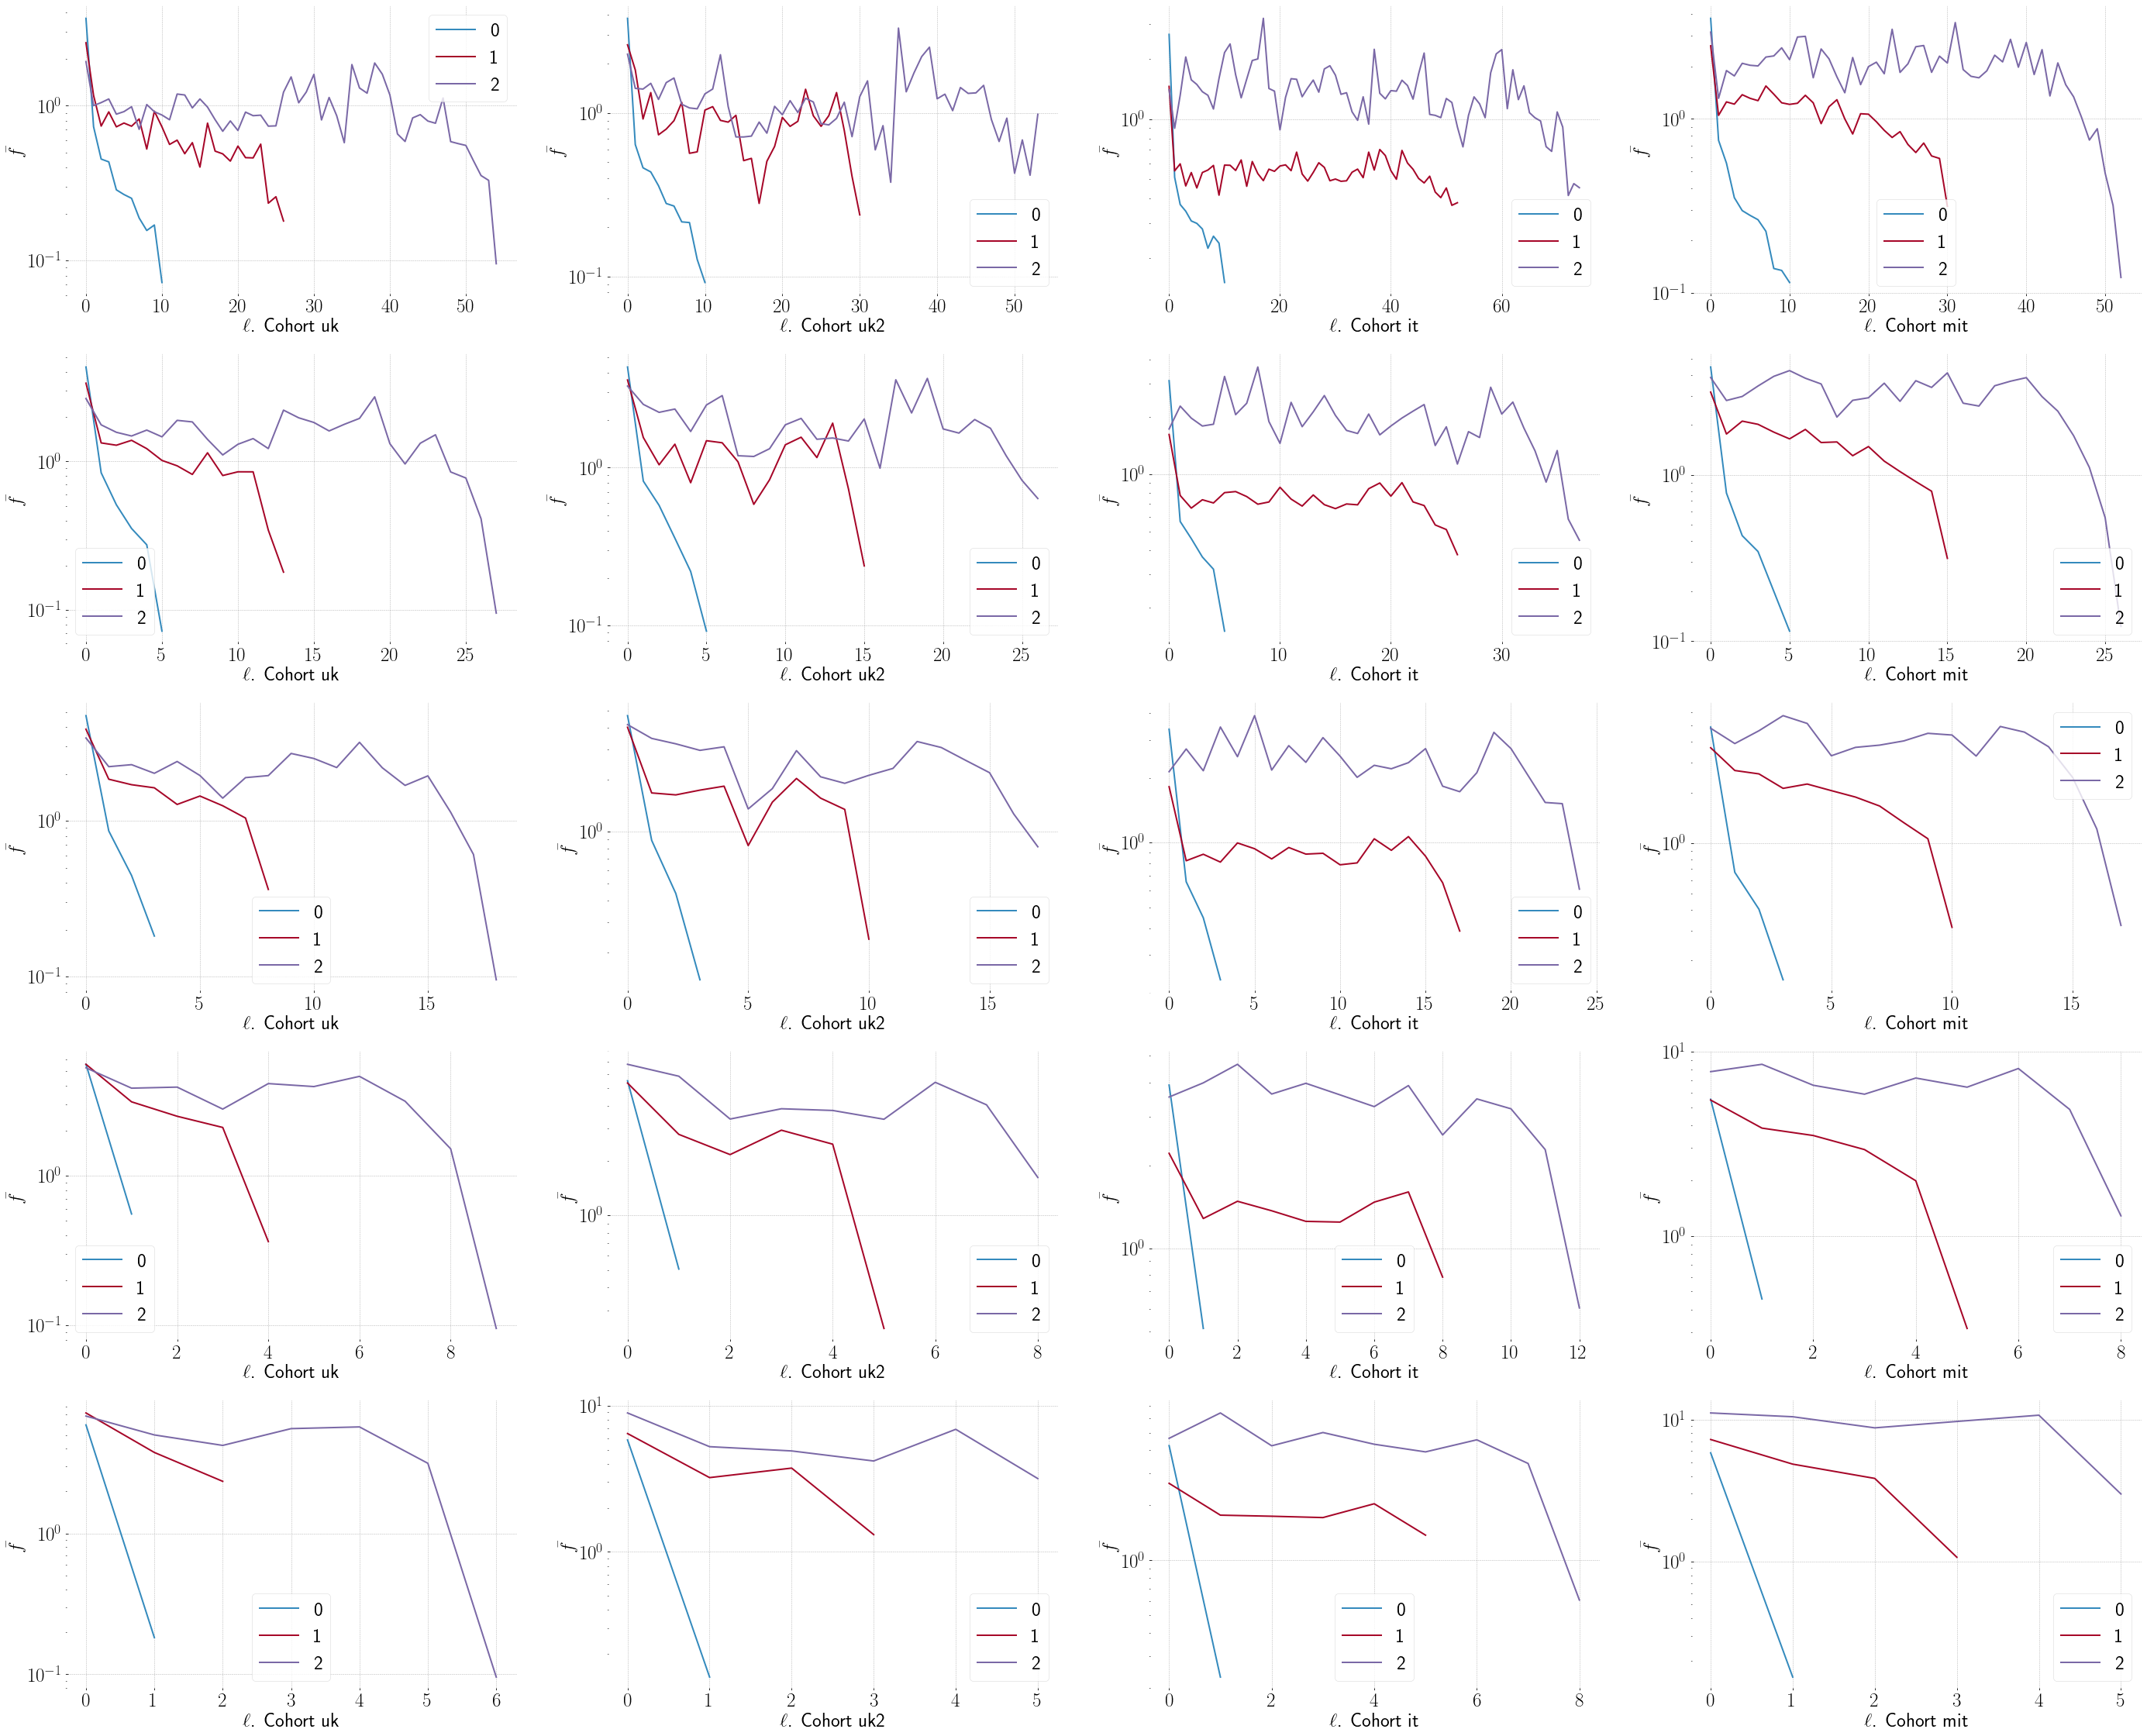

In [14]:
plt.figure(figsize=(12*4, 8*5))
p = 1
for Da in [5, 10, 15, 30, 45]:
    for c in ['uk', 'uk2', 'it', 'mit']:
        plt.subplot(5,4,p)
        plt.xlabel(fr'$\ell$. Cohort {c}')
        plt.ylabel(r'$\bar{f}$')
        plt.semilogy()
        for i in range(3):
            plt.plot(Deltaa[c][Da][i]['f'].index, Deltaa[c][Da][i]['f']['f'], label=f'{i}')
        plt.legend()
        p += 1

In [15]:
tmp = pd.DataFrame(index=range(60))
for c in Deltaa.keys():
    for Da in Deltaa[c].keys():
        for i in range(3):
            df = Deltaa[c][Da][i]['f']
            df.index *= Da
            df = df.reset_index()
            if c != 'uk2':
                df.columns = [f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            else:
                df.columns = [f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')

In [16]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S2.5.dat", index=False, sep="\t", header=True)

In [17]:
tmp

ukDax0    ukDay0  ukDax1    ukDay1  ukDax2    ukDay2  ukDbx0    ukDby0  \
0      0.0  3.662629     0.0  2.548431     0.0  1.925860     0.0  4.320821   
1      5.0  0.731324     5.0  1.164406     5.0  1.000440    10.0  0.839558   
2     10.0  0.452249    10.0  0.738499    10.0  1.046908    20.0  0.511434   
3     15.0  0.433786    15.0  0.912191    15.0  1.104928    30.0  0.354108   
4     20.0  0.286256    20.0  0.730104    20.0  0.881522    40.0  0.275115   
..     ...       ...     ...       ...     ...       ...     ...       ...   
70     NaN       NaN     NaN       NaN     NaN       NaN     NaN       NaN   
71     NaN       NaN     NaN       NaN     NaN       NaN     NaN       NaN   
72     NaN       NaN     NaN       NaN     NaN       NaN     NaN       NaN   
73     NaN       NaN     NaN       NaN     NaN       NaN     NaN       NaN   
74     NaN       NaN     NaN       NaN     NaN       NaN     NaN       NaN   

    ukDbx1    ukDby1  ...  mitDdx1   mitDdy1  mitDdx2   mitDdy2  mitDex0  \
0      0.0  3.363515  ...      0.0  5.467909      0.0  7.798057      0.0   
1     10.0  1.333249  ...     30.0  3.851313     30.0  8.548079     45.0   
2     20.0  1.286108  ...     60.0  3.511486     60.0  6.578705      NaN   
3     30.0  1.387742  ...     90.0  2.945101     90.0  5.884562      NaN   
4     40.0  1.219736  ...    120.0  1.994496    120.0  7.199936      NaN   
..     ...       ...  ...      ...       ...      ...       ...      ...   
70     NaN       NaN  ...      NaN       NaN      NaN       NaN      NaN   
71     NaN       NaN  ...      NaN       NaN      NaN       NaN      NaN   
72     NaN       NaN  ...      NaN       NaN      NaN       NaN      NaN   
73     NaN       NaN  ...      NaN       NaN      NaN       NaN      NaN   
74     NaN       NaN  ...      NaN       NaN      NaN       NaN      NaN   

     mitDey0  mitDex1   mitDey1  mitDex2    mitDey2  
0   5.822649      0.0  7.233006      0.0  11.126020  
1   0.153597     45.0  4.851997     45.0  10.461178  
2        NaN     90.0  3.849142     90.0   8.738758  
3        NaN    135.0  1.072454    135.0   9.693413  
4        NaN      NaN       NaN    180.0  10.729605  
..       ...      ...       ...      ...        ...  
70       NaN      NaN       NaN      NaN        NaN  
71       NaN      NaN       NaN      NaN        NaN  
72       NaN      NaN       NaN      NaN        NaN  
73       NaN      NaN       NaN      NaN        NaN  
74       NaN      NaN       NaN      NaN        NaN  

[75 rows x 120 columns]

## $\bar{f}$ with a random sample of $\bar{f_{i}}$
For all cohorts

In [40]:
calls.keys()

dict_keys(['uk', 'uk2', 'mit'])

In [42]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk1'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

fig1 = {}
for c in ['uk', 'uk1', 'uk2', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15)
        
fig1['it'] = {}
for i in range(3):
    fig1['it'][i] = {}
    fig1['it'][i]['f'] = pc.get_avgfa(itdffa15[60], itlives[60], limits['it'][i][0], limits['it'][i][1])
    fig1['it'][i]['fi'] = {}
    for ego in itdffa15[60].keys():
        tmp = {ego: itdffa15[60][ego]}
        fig1['it'][i]['fi'][ego] = pc.get_avgfa(tmp, itlives[60], limits['it'][i][0], limits['it'][i][1])
        
dashed = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb >= 0:
#             points = pc.get_plateau(fig1[c][lamb]['f'], pstar=0.01)
            points = pc.get_b_slopes(fig1[c][lamb]['f'])
#             dashed[c][lamb] = [[x[0] for x in points], [y[1] for y in points]]
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================uk=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.654265084574468) -- (axis cs: 2, 0.654265084574468);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.4581887315198958) -- (axis cs: 7, 1.4581887315198958);
\draw[dashed, ekans, ultra thick] (axis cs: 5, 2.2256547446074486) -- (axis cs: 13, 2.2256547446074486);
=======================uk1=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 1.1866094969061072) -- (axis cs: 2, 1.1866094969061072);
\draw[dashed, squirtle, ultra thick] (axis cs: 3, 2.859485724114207) -- (axis cs: 4, 2.859485724114207);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 2.899554654685301) -- (axis cs: 16, 2.899554654685301);
=======================uk2=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.6647318258067262) -- (axis cs: 2, 0.6647318258067262);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.5923360902462018) -- (axis cs: 7, 1.5923360902462018);
\draw

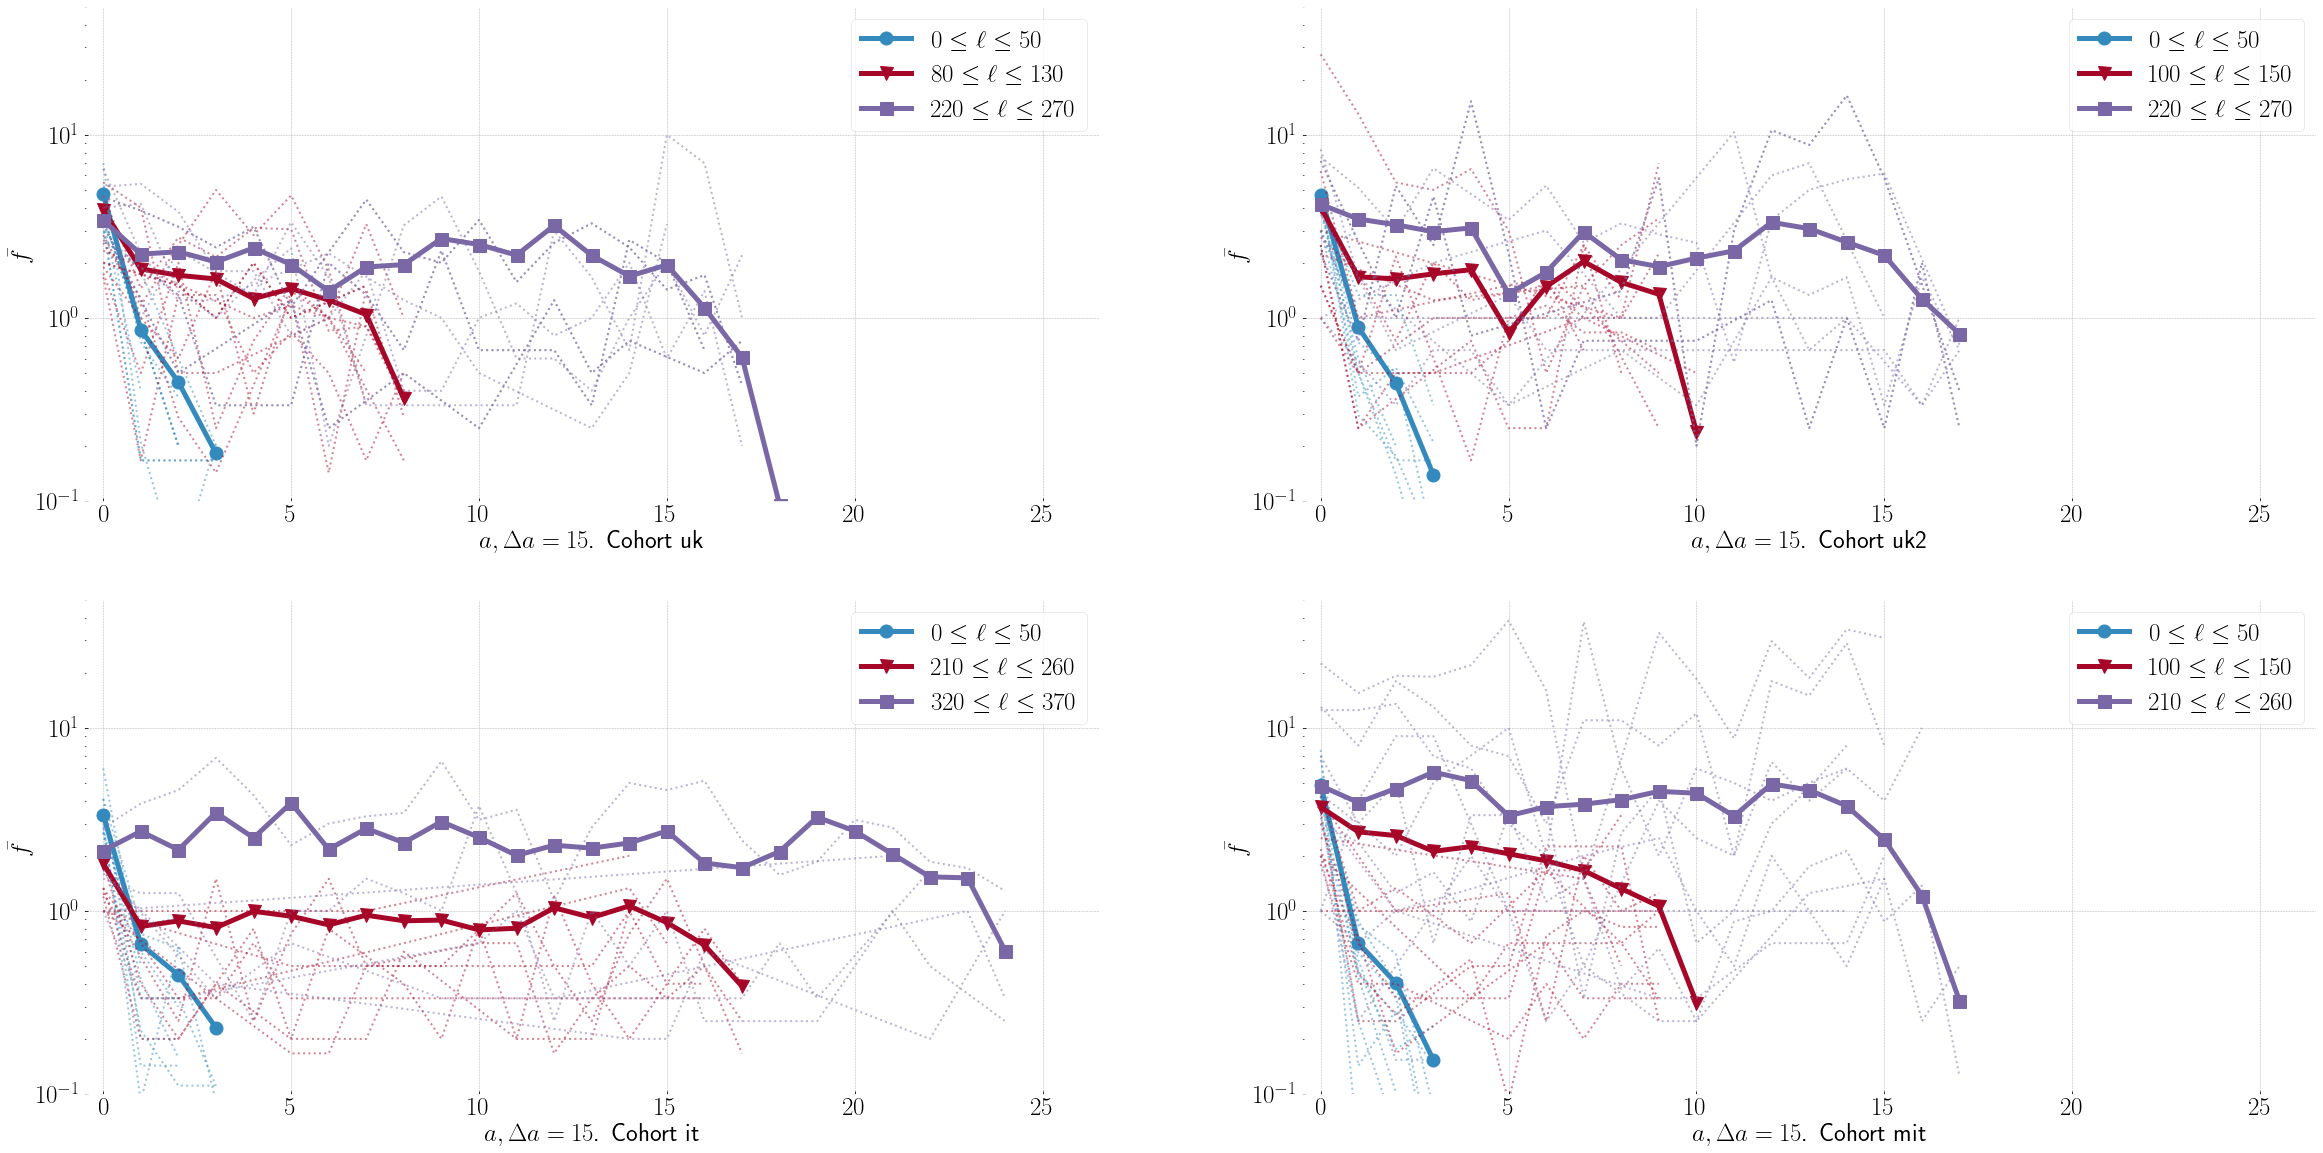

In [19]:
np.random.seed(2)
tmp = pd.DataFrame(index=range(25))
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    plt.ylim(10**(-1), 5*10**1)
    plt.semilogy()
    plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=5, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]}$')
        df = fig1[c][i]['f'].copy(deep=True)
        df.columns = [f'{c}{i}avg']
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
        egos = np.random.choice(list(fig1[c][i]['fi'].keys()), size=10)
        en = 1
        for e in egos:
            plt.plot(fig1[c][i]['fi'][e].index, fig1[c][i]['fi'][e]['f'], marker="", ls="dotted", lw=2, c=colors[i], alpha=0.5)
            df = fig1[c][i]['fi'][e].copy(deep=True)
            df.columns = [f'{c}{i}e{en}']
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            en += 1
    plt.legend()
    p += 1
# plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA.pdf", dpi=200)

In [20]:
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S3.dat", header=True, index=True, sep="\t")

## Different tests for $b(\ell)$

In [12]:
def get_b_olstocenter(series, pstar=0.1):
    for i in range(max(series.index) // 2):
        df = series.loc[(series.index >= (0 + i)) & (series.index <= (max(series.index) - i))]
        X = sm.add_constant(series.index)
        Y = series['f']
        tmp = sm.OLS(Y, X).fit()
        if tmp.pvalues[1] > pstar:
            df = series.loc[(series.index >= (0 + i - 1)) & (series.index <= (max(series.index) - i + 1))]
            xo = min(df.index)
            xf = max(df.index)
            yo = np.mean(df['f'])
            yf = yo
            return [[xo, xf], [yo, yf]]
    else:
        df = series.loc[(series.index >= (0 + 1)) & (series.index <= (max(series.index) - 1))]
        xo = min(df.index)
        xf = max(df.index)
        yo = np.mean(df['f'])
        yf = yo
        return [[xo, xf], [yo, yf]]
    
def get_b_slopes(series, patternsize=3):
    allslopes = []
    X = list(series.index)
    N = len(X)
    xo, xf = X[0], X[-1]
    yo, yf = series.at[xo, 'f'], series.at[xf, 'f']
    slope = (yf - yo) / (xf - xo)
    allslopes.append(slope)
    for i in range(1, N):
        newx = X[i // 2: N - ((i + 1) // 2)]
        if len(newx) > 1:
            xo, xf = newx[0], newx[-1]
            yo, yf = series.at[xo, 'f'], series.at[xf, 'f']
            slope = (yf - yo) / (xf - xo)
            allslopes.append(slope)
        else:
            xo, xf = X[1], X[-2]
            df = series.loc[(series.index >= xo) & (series.index <= xf)]
            yo = np.mean(df['f'])
            yf = yo
            return [[xo, xf], [yo, yf]]
        if (len(allslopes) >= patternsize):
            checkSlopes = list(np.sign(allslopes[-patternsize:]))
            if checkSlopes.count(checkSlopes[0]) != len(checkSlopes):
                df = series.loc[(series.index >= xo) & (series.index <= xf)]
                yo = np.mean(df['f'])
                yf = yo
                return [[xo, xf], [yo, yf]]

def get_b_mk(series):
    for i in range(max(series.index) // 2):
        df = series.loc[(series.index >= (0 + i)) & (series.index <= (max(series.index) - i))]
        tmp = mk.original_test(df['f'])
        if tmp[0] == 'no trend':
            df = series.loc[(series.index >= (0 + i - 1)) & (series.index <= (max(series.index) - i + 1))]
            xo = min(df.index)
            xf = max(df.index)
            yo = np.mean(df['f'])
            yf = yo
            return [[xo, xf], [yo, yf]]
    else:
        df = series.loc[(series.index >= (0 + 1)) & (series.index <= (max(series.index) - 1))]
        xo = min(df.index)
        xf = max(df.index)
        yo = np.mean(df['f'])
        yf = yo
        return [[xo, xf], [yo, yf]]

In [43]:
maxa = {}
for c in calls.keys():
    maxa[c] = max(calls[c]['aclock'])
maxit = 0
for ego in itlives[60].keys():
    for alter in itlives[60][ego].keys():
        if itlives[60][ego][alter]['ell'] > maxit:
            maxit = itlives[60][ego][alter]['ell']
maxa['it'] = maxit
maxa

{'uk': 482, 'uk1': 481, 'uk2': 291, 'mit': 442, 'it': 633}

In [44]:
t0 = dt.datetime.now()
tests = ['olsToEnds', 'olsToCenter', 'mk', 'slopes']
functs = [pc.get_plateau, get_b_olstocenter, get_b_mk, get_b_slopes]
fa = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    fa[c] = {}
    for t in tests:
        fa[c][t] = {}
    for ell in range(maxa[c]):
        if c == 'it':
            curve  = {'f': pc.get_avgfa(itdffa15[60], itlives[60], ell, ell + 50)}
        else:
            curve = pc.get_fal(calls[c], ell, ell + 50, 15)
        if len(curve['f']) > 3:
            for ft in range(len(tests)):
                points = functs[ft](curve['f'])
                fa[c][tests[ft]][ell] = points[1][1]
    for t in fa[c].keys():
        fa[c][t] = pd.DataFrame.from_dict(fa[c][t], orient='index').sort_index()
print(f'Took {dt.datetime.now() - t0}')

/opt/homebrew/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


Took 0:01:49.350277


In [49]:
tmp = pd.DataFrame(index=range(366))
for c in fa.keys():
    for test in ['mk', 'slopes']:
        df = fa[c][test].loc[fa[c][test].index <= 365]
        df[f'{c}{test}'] = df[0].rolling(window=50).mean()
        df = df.drop(columns=[0])
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')

/var/folders/c1/dbn37n492mz65yl47z1jb0sc0000gn/T/ipykernel_2835/770552025.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{c}{test}'] = df[0].rolling(window=50).mean()


In [51]:
df

mitslopes
0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
..         ...
361   0.678519
362   0.661287
363   0.643654
364   0.626021
365   0.615296

[366 rows x 1 columns]

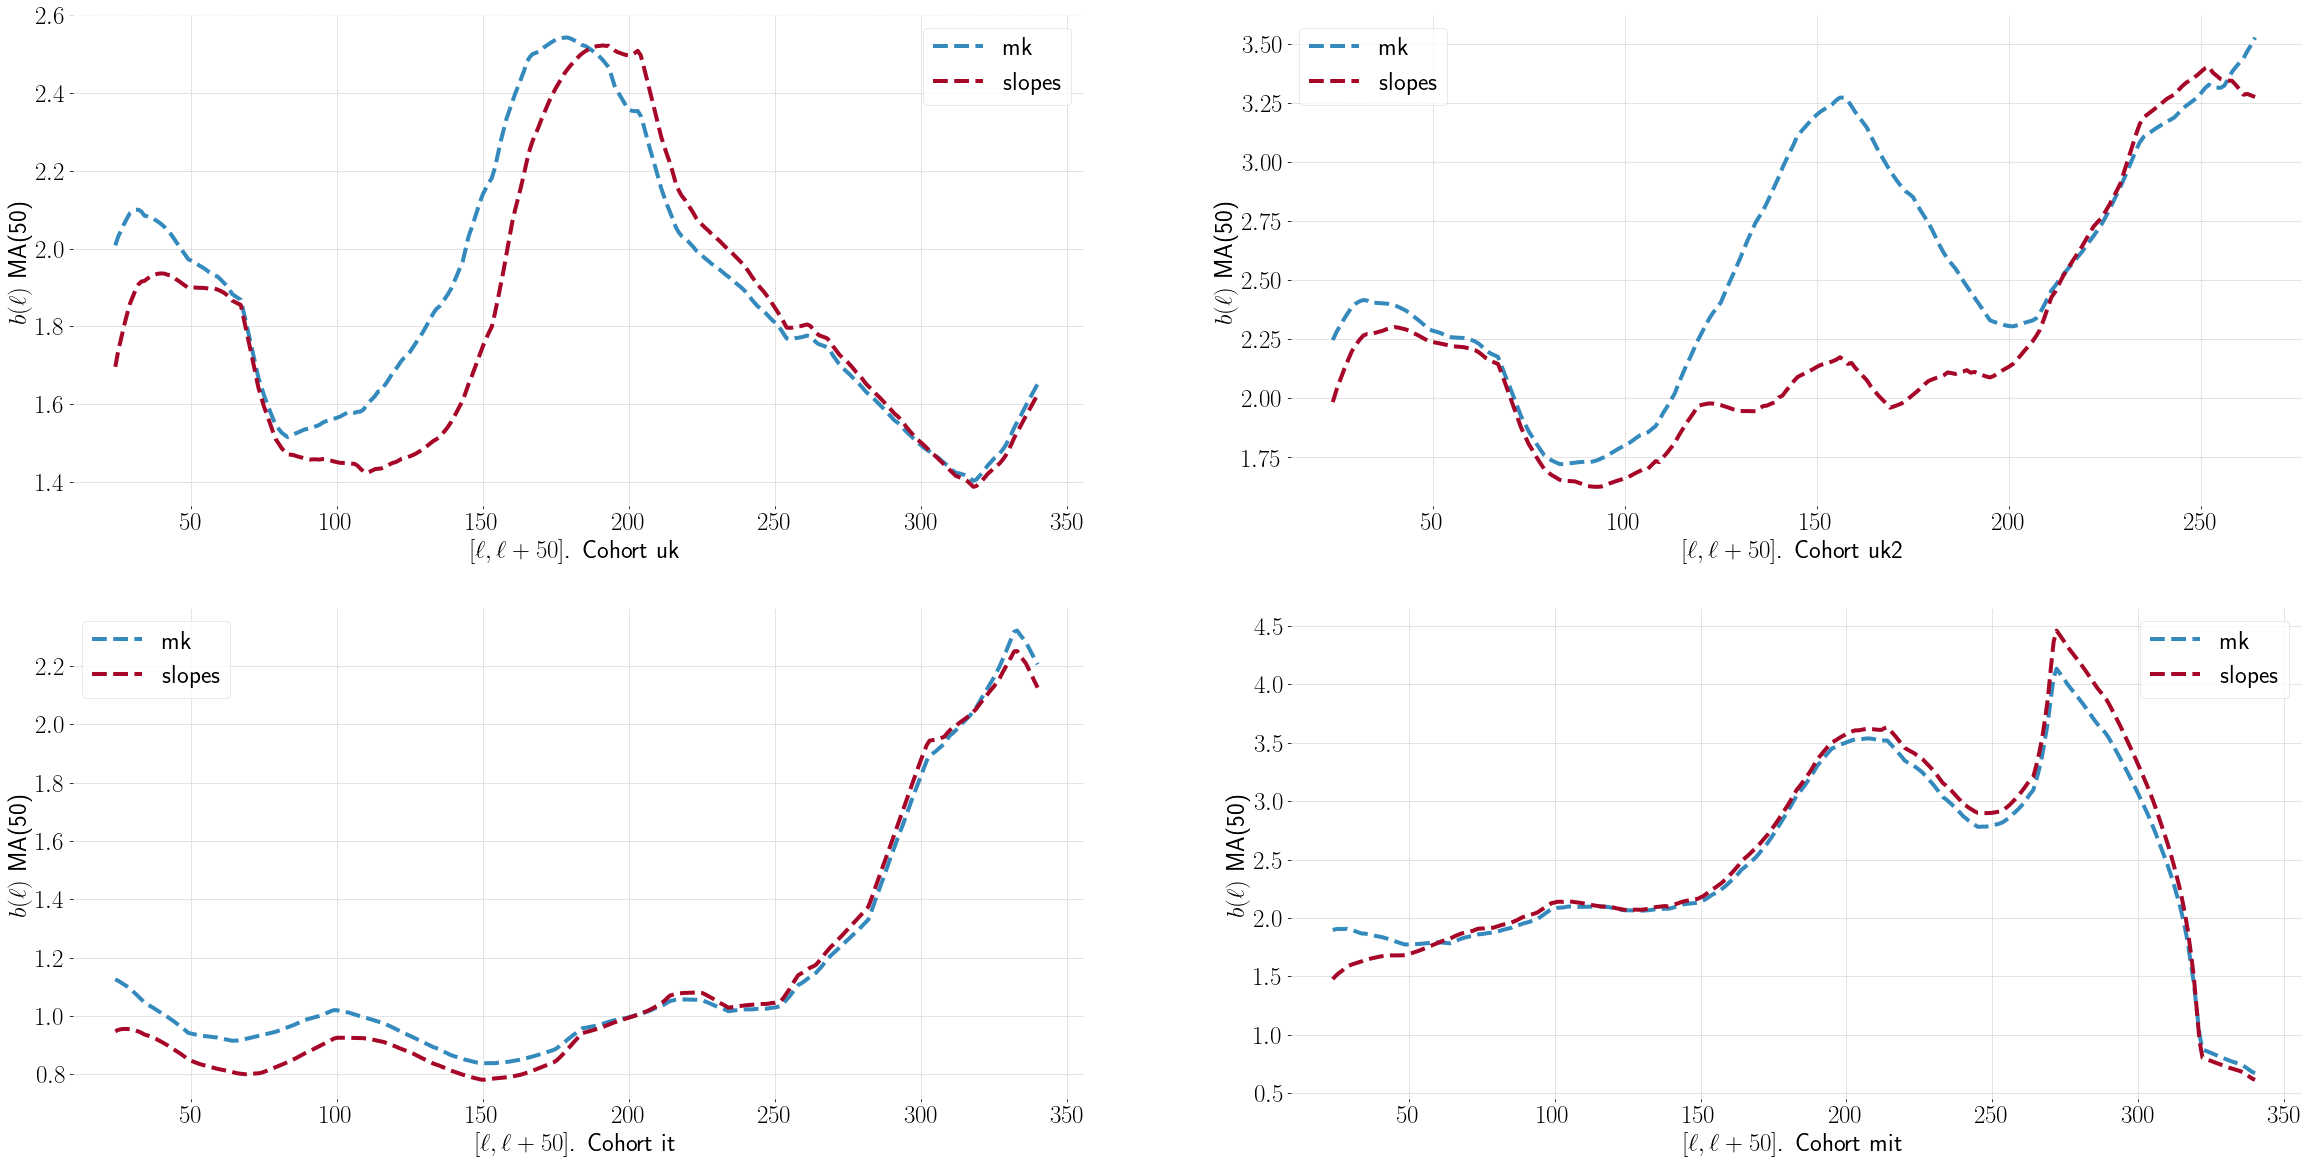

In [52]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel(fr"$[\ell, \ell + 50]$. Cohort {c}")
    plt.ylabel(r"$b(\ell)$ MA(50)")
    for test in ['mk', 'slopes']:
        plt.plot([x - 25 for x in tmp.index], tmp[f'{c}{test}'], markersize=13, ls="dashed", lw=4, label=test)
    plt.legend()
    p += 1

In [48]:
tmp = pd.DataFrame(index=range(500))
for c in ['uk1']:
    for test in range(1, 3):
        df = fa[c][['mk', 'slopes'][test]].loc[fa[c][['mk', 'slopes'][test]].index <= 500]
        df[f'{c}{test}'] = df[0].rolling(window=50).mean()
        df = df.drop(columns=[0])
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')

ukmk  ukslopes     uk1mk  uk1slopes  uk2mk  uk2slopes      itmk  \
0         NaN       NaN       NaN        NaN    NaN        NaN       NaN   
1         NaN       NaN       NaN        NaN    NaN        NaN       NaN   
2         NaN       NaN       NaN        NaN    NaN        NaN       NaN   
3         NaN       NaN       NaN        NaN    NaN        NaN       NaN   
4         NaN       NaN       NaN        NaN    NaN        NaN       NaN   
..        ...       ...       ...        ...    ...        ...       ...   
361  1.596546  1.569948  1.625699   1.601312    NaN        NaN  2.280926   
362  1.610511  1.583548  1.640257   1.615374    NaN        NaN  2.261640   
363  1.624348  1.596936  1.655132   1.629651    NaN        NaN  2.242971   
364  1.637833  1.610371  1.669517   1.643798    NaN        NaN  2.223092   
365  1.652009  1.624596  1.684609   1.658745    NaN        NaN  2.205015   

     itslopes     mitmk  mitslopes  
0         NaN       NaN        NaN  
1         NaN       NaN        NaN  
2         NaN       NaN        NaN  
3         NaN       NaN        NaN  
4         NaN       NaN        NaN  
..        ...       ...        ...  
361  2.208166  0.736253   0.678519  
362  2.187579  0.718359   0.661287  
363  2.167661  0.700791   0.643654  
364  2.146519  0.683222   0.626021  
365  2.125220  0.672563   0.615296  

[366 rows x 10 columns]

In [26]:
# tmp = tmp.fillna('nan')
# tmp.index = [x - 25 for x in tmp.index]
# tmp = tmp.loc[tmp.index >= 24]
# tmp.index.rename('a', inplace=True)
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S4.dat", sep="\t")

## Individual egos and their plateaus

In [27]:
t0 = dt.datetime.now()

limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

fig1 = {}
for c in ['uk', 'uk2', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15)
        
fig1['it'] = {}
for i in range(3):
    fig1['it'][i] = {}
    fig1['it'][i]['f'] = pc.get_avgfa(itdffa15[60], itlives[60], limits['it'][i][0], limits['it'][i][1])
    fig1['it'][i]['fi'] = {}
    for ego in itdffa15[60].keys():
        tmp = {ego: itdffa15[60][ego]}
        fig1['it'][i]['fi'][ego] = pc.get_avgfa(tmp, itlives[60], limits['it'][i][0], limits['it'][i][1])
        
dashed = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    for lamb in fig1[c].keys():
        points = get_b_slopes(fig1[c][lamb]['f'])
        dashed[c][lamb] = points[1][1]
            
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.833449


In [28]:
bhist = {}
for c in fig1.keys():
    bhist[c] = {}
    for lamb in fig1[c].keys():
        bhist[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve = fig1[c][lamb]['fi'][ego]
            if len(curve > 1):
                b = pc.get_b_slopes(curve)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist[c][lamb].append(b[1][1])
                    
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

/Users/vsvh/Documents/research/comm_patterns_git/phonecalls.py:679: RuntimeWarning: invalid value encountered in double_scalars
  slope = (yf - yo) / (xf - xo)


In [29]:
tmp = pd.DataFrame()
for c in ['uk', 'uk2', 'it', 'mit']:
    for lamb in range(3):
        hist = histogram(bhist[c][lamb], 5, log=False)
        tmp[f'{c}x{lamb}'] = hist['label']
        tmp[f'{c}y{lamb}'] = hist['pmf']

In [30]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S5.dat", sep="\t", index=False)

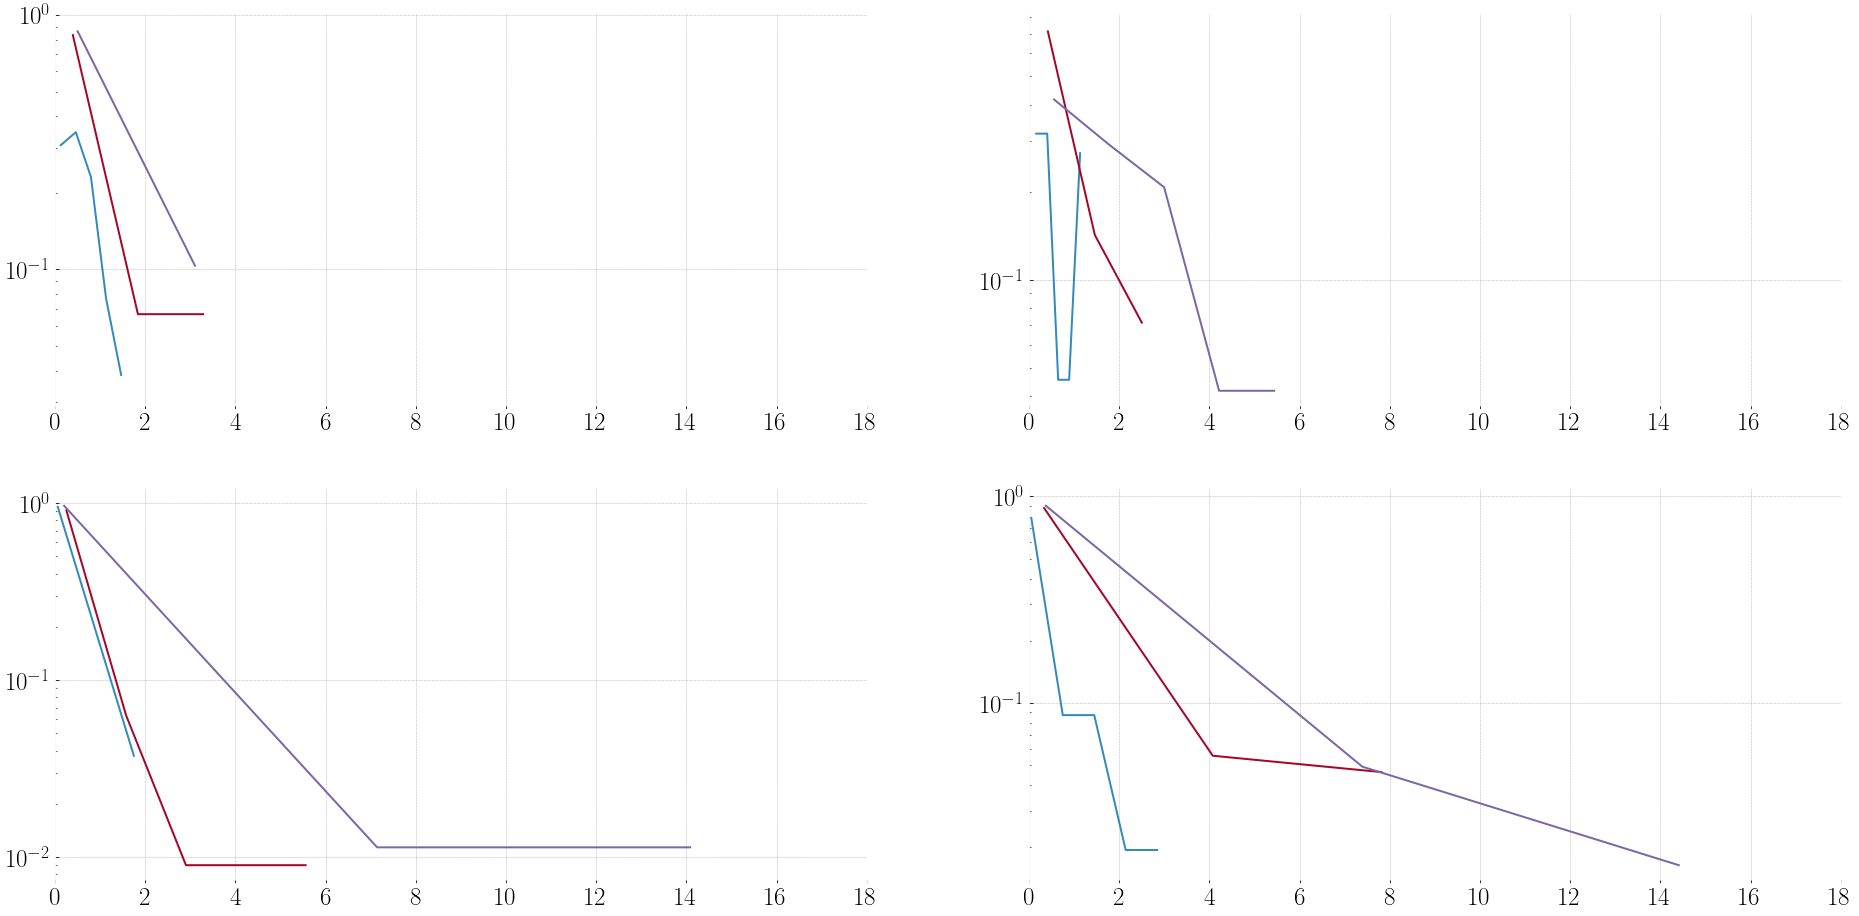

In [31]:
plt.figure(figsize=(16*2, 8*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.semilogy()
    plt.xlim(0, 18)
    for lamb in range(3):
        plt.plot(tmp[f'{c}x{lamb}'], tmp[f'{c}y{lamb}'])
    p += 1

## $p$-value distribution for the KS test

In [32]:
ksp = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

============	UK	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8534285714285715, 0.04) (0.8534285714285715, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.646031746031746, 0.04) (0.646031746031746, 1)};
============	UK2	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8125850340136055, 0.04) (0.8125850340136055, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.6950757575757575, 0.04) (0.6950757575757575, 1)};
============	IT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8681966417260535, 0.04) (0.8681966417260535, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.8444142544761739, 0.04) (0.8444142544761739, 1)};
============	MIT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.7817754262198706, 0.04) (0.7817754262198706, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.7682993236271923, 0.04) (0.7682993236271923, 1)};


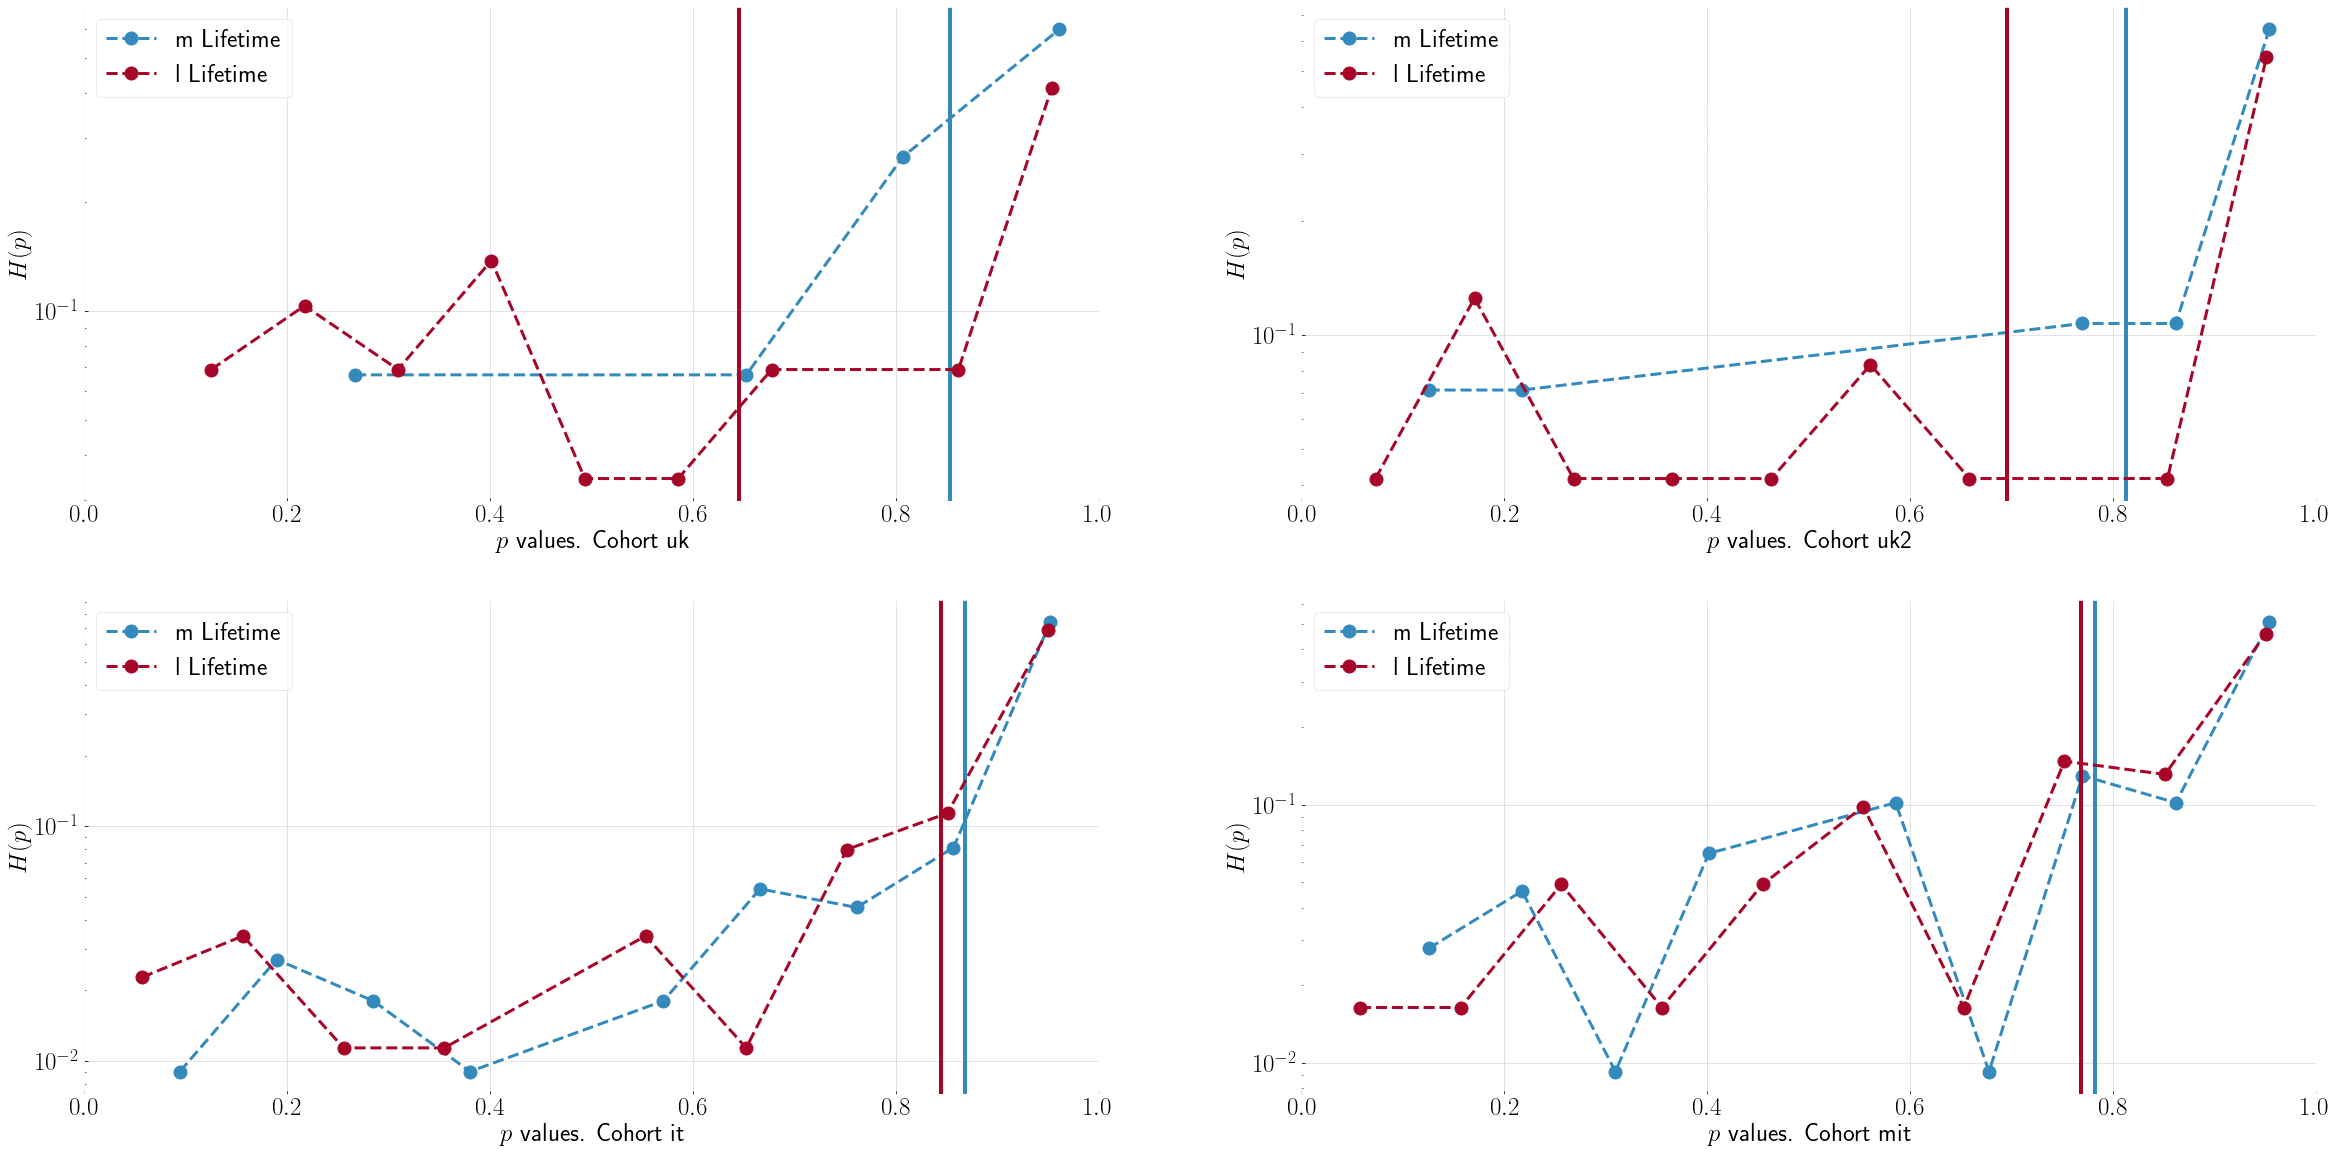

In [33]:
tmp = pd.DataFrame(index=range(10))
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ksp.keys():
    print(f'============\t{c.upper()}\t=================')
    plt.subplot(2, 2, p)
    plt.semilogy()
    plt.xlim(0, 1)
    plt.xlabel(fr"$p$ values. Cohort {c}")
    plt.ylabel(r'$H(p)$')
    m = 0
    for s in ['m', 'l']:
        H = pc.histogram(ksp[c][s], 10, log=False)
        H['tmp'] = H['label'] * H['h']
        avg = sum(H['tmp']) / sum(H['h'])
        tmp[f'{c}x{s}'] = H['label']
        tmp[f'{c}y{s}'] = H['pmf']
        print(f'\\addplot[{dict({"m": "squirtle", "l": "ekans"})[s]}, dashed, line width = 4] coordinates{{({avg}, 0.04) ({avg}, 1)}};')
        plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, c=colors[m], label=f"{s} Lifetime")
        plt.axvline(avg, ls="solid", lw=4, c=colors[m])
        m += 1
    plt.legend()
    p += 1
# plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA1.pdf")

## Fig 3 (survival curves) separated by country

In [34]:
dff = {}
dff['all'] = {}
for c in calls.keys():
    dff[c] = pc.get_f(calls[c], 'all', 30, 10)
    if c != 'uk2':
        dff['all'].update(dff[c])
    
dff['it'] = itdffa30[60]
dff['all'].update(dff['it'])

SI7 = {}
for c in dff.keys():
    SI7[c] = pc.get_survival(dff[c], lambdamax=25)

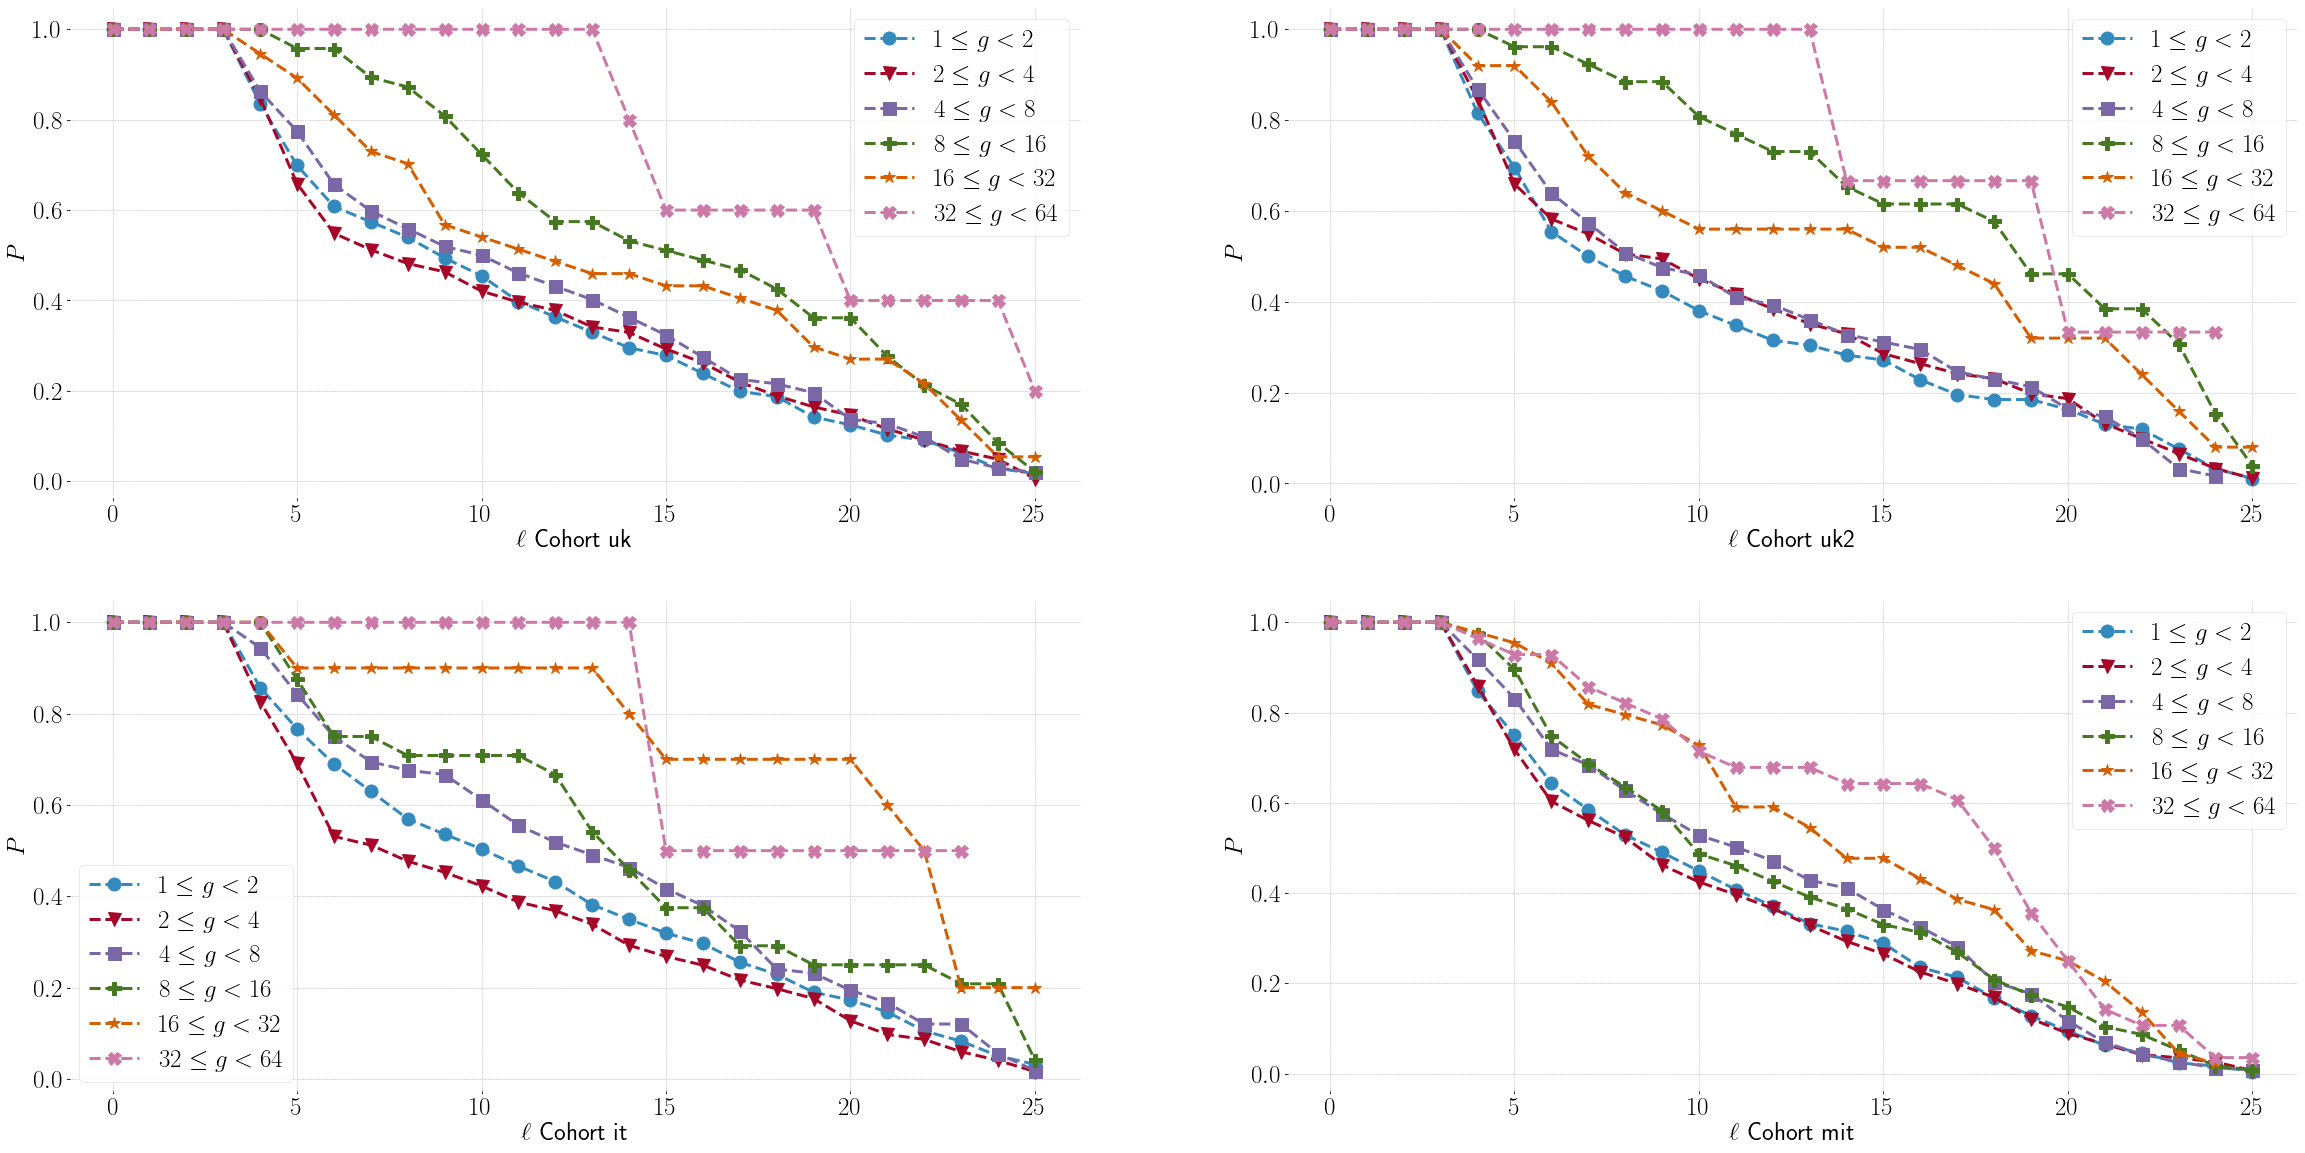

In [35]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel(fr"$\ell$ Cohort {c}")
    plt.ylabel(r"$P$")
    for i in range(6):
        plt.plot(SI7[c][i].index, SI7[c][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
    plt.legend()
    p += 1

In [36]:
tmp = pd.DataFrame(index=range(26))
for c in ['uk', 'uk2', 'mit', 'it']:
    for i in range(1, 6):
        tmp[f'{c}{i}'] = SI7[c][i]

In [37]:
# tmp.index.rename('a', inplace=True)
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S7.dat", header=True, sep="\t")

## Fig 3 with different values for $a_o$ and $a_f$

In [38]:
lives['all'] = {}
for c in ['uk', 'mit', 'it']:
    lives['all'].update(lives[c])

NameError: name 'lives' is not defined

In [ ]:
SI8 = {}
dff = {}
for c in ['uk', 'mit', 'it']:
    if c != 'it':
        dft = pc.get_f(calls[c], 'all', 30, 10)
        dff.update(dft)
    else:
        dft = itdffa30[60]
        dff.update(dft)

for letter in [0,1,2]:
    SI8[{0:'a', 1:'b', 2:'c'}[letter]] = pc.get_survival(dff, lambdamax=25, alphafixed=letter)

In [ ]:
dff = {}
for c in ['uk', 'mit', 'it']:
    if c != 'it':
        dft = pc.get_f(calls[c], 'all', 15, 10)
        dff.update(dft)
    else:
        dft = itdffa15[60]
        dff.update(dft)
        
SI8['d'] = pc.get_survival(dff, lambdamax=25, alphafixed=2, externalell=lives['all'])
SI8['e'] = pc.get_survival(dff, lambdamax=25, alphafixed=(2,4), externalell=lives['all'])
SI8['f'] = pc.get_survival(dff, lambdamax=25, alphafixed=(2,5), externalell=lives['all'])

In [ ]:
plt.figure(figsize=(12*3, 8*2))
p = 1
for c in SI8.keys():
    plt.subplot(2,3,p)
    for i in range(1,6):
        plt.plot(SI8[c][i].index, SI8[c][i][0], label=c)
    plt.legend()
    p += 1

In [ ]:
tmp = pd.DataFrame(index=[idx * 1 for idx in range(26)])
for c in SI8.keys():
    for i in range(1,6):
        tmp[f'{c}{i}'] = SI8[c][i][0]

In [ ]:
# tmp.index *= 10
# tmp.index.rename('a', inplace=True)
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S8.dat", header=True, sep="\t")

## Obtain $\ell_{s}$ by cohort and for all data

In [98]:
def get_b_slopes(series, patternsize=3, FlagConverge=False):
    allslopes = []
    X = list(series.index)
    N = len(X)
    xo, xf = X[0], X[-1]
    yo, yf = series.at[xo, 'f'], series.at[xf, 'f']
    slope = (yf - yo) / (xf - xo)
    allslopes.append(slope)
    for i in range(1, N):
        newx = X[i // 2: N - ((i + 1) // 2)]
        if len(newx) > 1:
            xo, xf = newx[0], newx[-1]
            yo, yf = series.at[xo, 'f'], series.at[xf, 'f']
            slope = (yf - yo) / (xf - xo)
            allslopes.append(slope)
        else:
            xo, xf = X[1], X[-2]
            df = series.loc[(series.index >= xo) & (series.index <= xf)]
            yo = np.mean(df['f'])
            yf = yo
            if FlagConverge:
                return [[xo, xf], [yo, yf], False]
            else:
                return [[xo, xf], [yo, yf]]
        if (len(allslopes) >= patternsize):
            checkSlopes = list(np.sign(allslopes[-patternsize:]))
            if checkSlopes.count(checkSlopes[0]) != len(checkSlopes):
                df = series.loc[(series.index >= xo) & (series.index <= xf)]
                yo = np.mean(df['f'])
                yf = yo
                if FlagConverge:
                    return [[xo, xf], [yo, yf], True]
                else:
                    return [[xo, xf], [yo, yf]]

In [99]:
t0 = dt.datetime.now()
b = {}
converge = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    b[c] = {}
    converge[c] = {}
    for ell in range(maxa[c]):
        if c == 'it':
            curve  = {'f': pc.get_avgfa(itdffa15[60], itlives[60], ell, ell + 50)}
        else:
            curve = pc.get_fal(calls[c], ell, ell + 50, 15)
        if len(curve['f']) > 2:
            points = get_b_slopes(curve['f'], FlagConverge=True)
            b[c][ell] = points[1][1]
            converge[c][ell] = points[2]
    b[c] = pd.DataFrame.from_dict(b[c], orient='index').sort_index().rename({0: 'b'}, axis='columns')
    tmp = pd.DataFrame.from_dict(converge[c], orient="index").sort_index().rename({0: 'converge'}, axis='columns')
    b[c] = b[c].merge(tmp, left_index=True, right_index=True, how='outer')
    b[c]['ma50'] = b[c]['b'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:01:18.629437


In [101]:
b['uk']

b  converge      ma50
0    0.654265     False       NaN
1    0.832471     False       NaN
2    0.912965     False       NaN
3    0.989685     False       NaN
4    1.075097     False       NaN
..        ...       ...       ...
477  7.127586      True  3.538759
478  3.870690      True  3.572354
479  4.028736      True  3.608561
480  4.028736      True  3.643641
481  4.482143      True  3.687464

[482 rows x 3 columns]

In [102]:
tildeb = {}
for c in b.keys():
    df = b[c].copy(deep=True)
    df1 = df.loc[df['converge'] == True]
    tildeb[c] = min(df1.index)

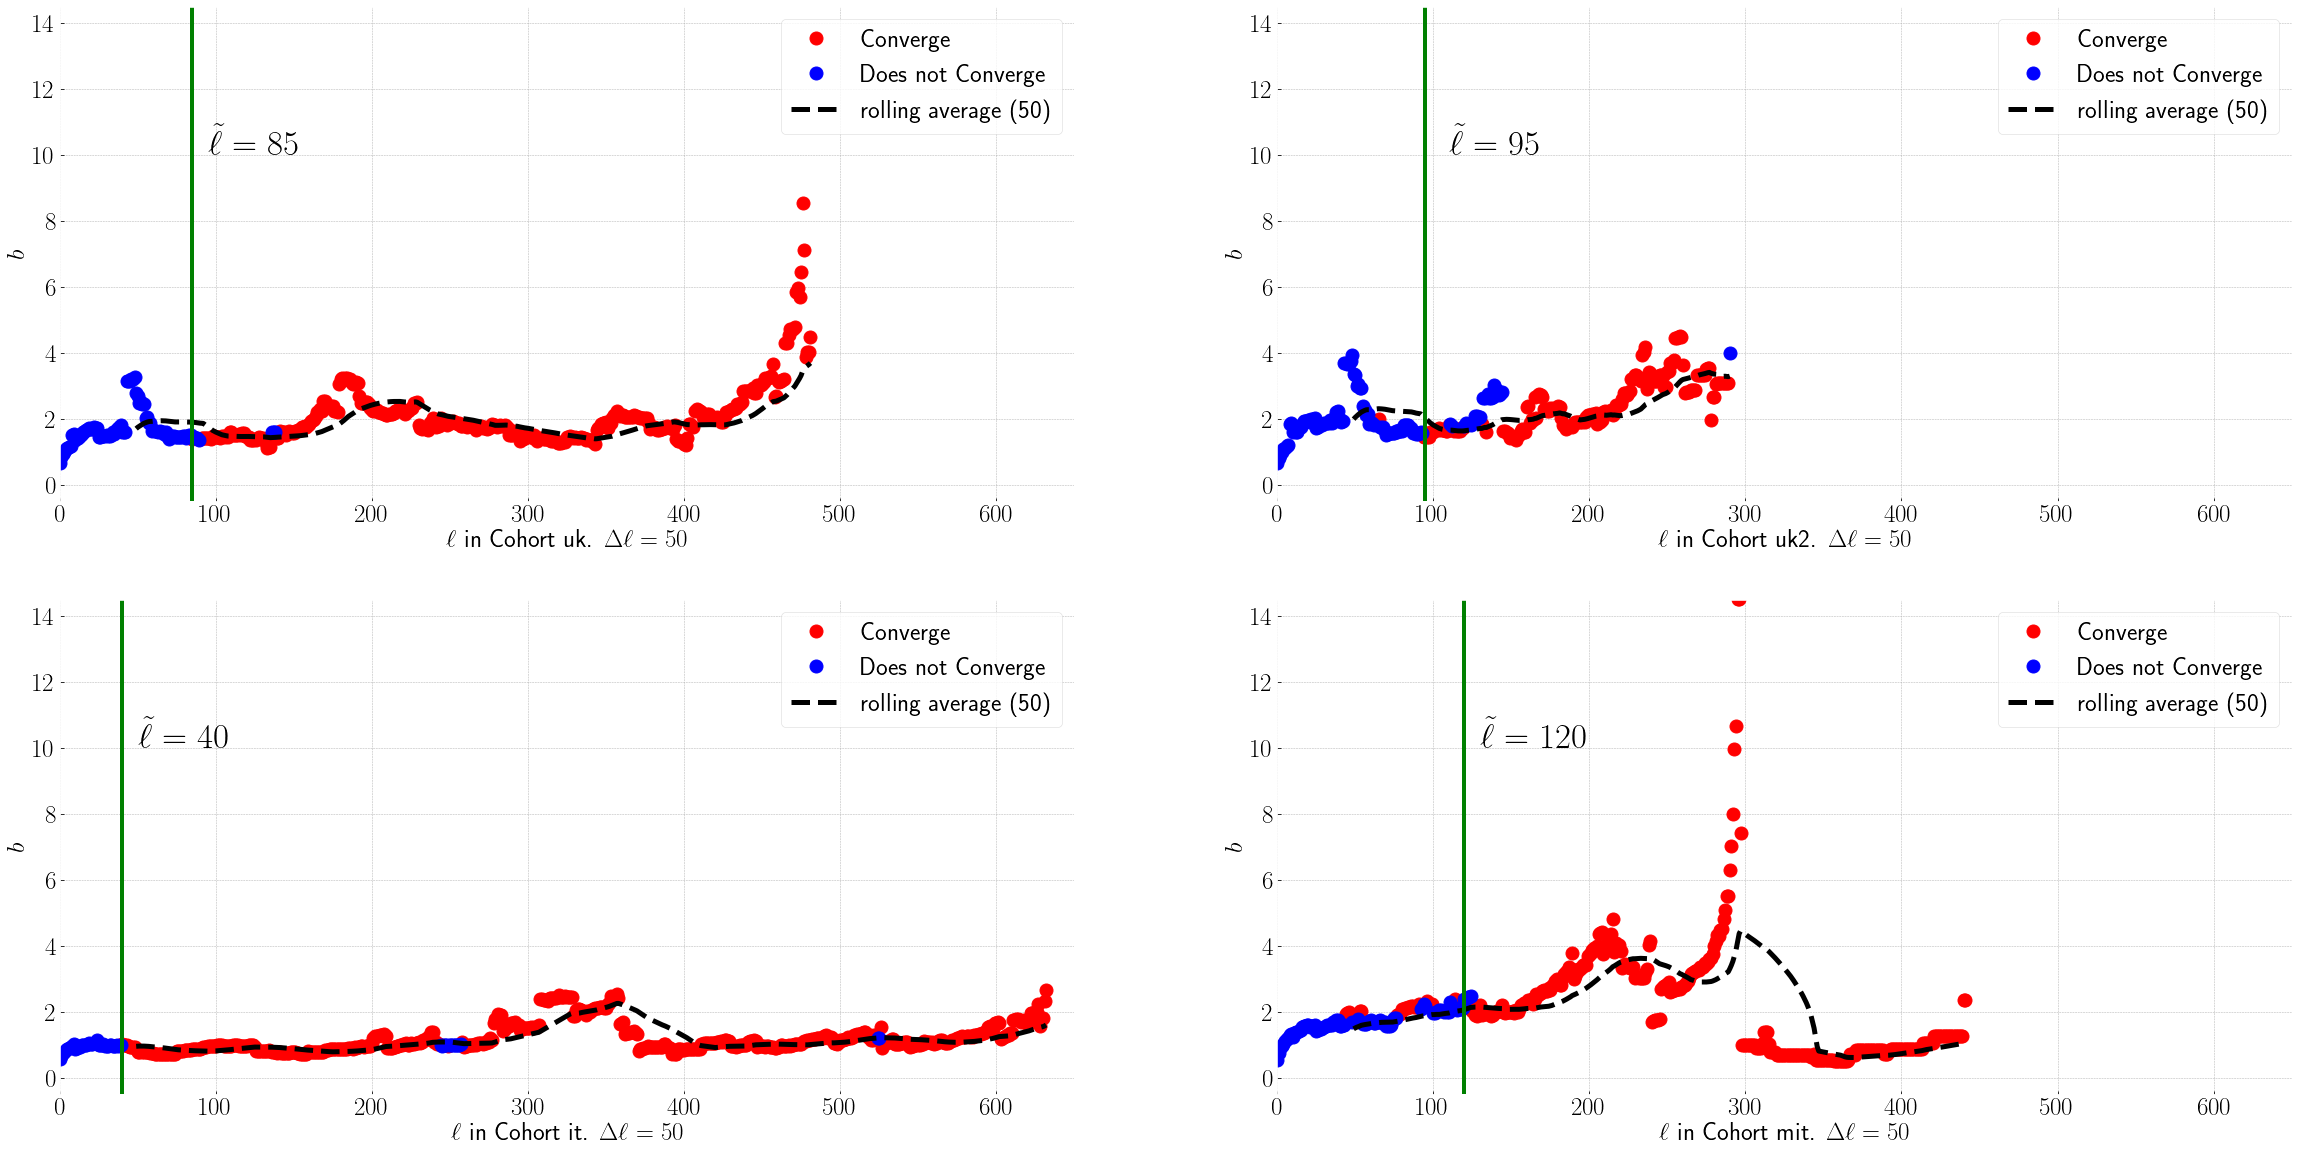

In [110]:
plt.figure(figsize=(20*2, 10*2))
p = 1
tmp = pd.DataFrame()
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    plt.xlabel(fr"$\ell$ in Cohort {c}. $\Delta \ell = 50$")
    plt.ylabel(r"$b$")
    plt.xlim(0, 650)
    plt.ylim(-0.5, 14.5)
    df = b[c].copy(deep=True)
    idx = pd.DataFrame({f'{c}ell': df.index})
    tmp = tmp.merge(idx, left_index=True, right_index=True, how='outer')
    abra = df[['ma50']]
    abra.columns = [f'{c}ma']
    tmp = tmp.merge(abra, left_on=f'{c}ell', right_index=True, how='outer')
    df1 = df.loc[df['converge'] == True]
    kadabra = df1[['b']]
    kadabra.columns = [f'{c}red']
    tmp = tmp.merge(kadabra, left_on=f'{c}ell', right_index=True, how='outer')
    df2 = df.loc[df['converge'] == False]
    alakazam = df2[['b']]
    alakazam.columns = [f'{c}blue']
    tmp = tmp.merge(alakazam, left_on=f'{c}ell', right_index=True, how='outer')
    plt.plot(df1.index, df1['b'], marker="o", markersize=13, c="red", ls="", label="Converge")
    plt.plot(df2.index, df2['b'], marker="o", markersize=13, c="blue", ls="", label="Does not Converge")
    plt.plot(df.index, df['ma50'], marker="", ls="dashed", lw=5, c="black", label="rolling average (50)")
    if c == 'uk2':
        plt.axvline(95, c="green", lw=4)
        plt.annotate(r'$\tilde{\ell} = 95$', (110, 10), fontsize=35)
    elif c == 'mit':
        plt.axvline(120, c="green", lw=4)
        plt.annotate(r'$\tilde{\ell} = 120$', (130, 10), fontsize=35)
    else:
        plt.axvline(tildeb[c], c="green", lw=4)
        plt.annotate(fr'$\tilde \ell = {tildeb[c]}$', (tildeb[c] + 10, 10), fontsize=35)
    plt.legend()
    p += 1

In [112]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S9.dat", index=False, header=True, sep="\t")

## Distribution of $g$

In [113]:
t0 = dt.datetime.now()
S10 = {}
for c in ['uk', 'uk2', 'mit']:
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lifetime = df.groupby('ea')[['aclock']].max()
    lifetime = lifetime.loc[lifetime['aclock'] <= 199]
    df = df[df['ea'].isin(lifetime.index)]
    g = df.groupby('ea')[['time']].count()
    Hall = pc.histogram(g['time'], 30)
    df2 = df.loc[(df['aclock'] >= 30) & (df['aclock'] <= 60)]
    g = df2.groupby('ea')[['time']].count()
    H = pc.histogram(g['time'], 30)
    S10[c] = (Hall, H)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.087377


# Redo Fig 1 combining both UK and both Italy

In [208]:
with open('../itdata/tmp/mtl_dffa15.pickle', 'rb') as handle:
    tmpdff = pickle.load(handle)
    handle.close()
    
with open('../itdata/tmp/mtl_livesd.pickle', 'rb') as handle:
    tmplives = pickle.load(handle)
    handle.close()
    
pikachu = {}
for it in ['it1', 'it2']:
    pikachu[it] = {}
    for ego in tmpdff[it][60].keys():
        thekey = {"it1": "a", "it2": "b"}
        pikachu[it][f'{thekey[it]}{ego}'] = tmpdff[it][60][ego]
        pikachu['it'] = pikachu.get('it', {})
        pikachu['it'][f'{thekey[it]}{ego}'] = {}
        pikachu['it'][f'{thekey[it]}{ego}'].update(tmpdff[it][60][ego])

raichu = {}
for it in ['it1', 'it2']:
    raichu[it] = {}
    for ego in tmplives[it][60].keys():
        thekey = {"it1": "a", "it2": "b"}
        raichu[it][f'{thekey[it]}{ego}'] = tmplives[it][60][ego]
        raichu['it'] = raichu.get('it', {})
        raichu['it'][f'{thekey[it]}{ego}'] = {}
        raichu['it'][f'{thekey[it]}{ego}'].update(tmplives[it][60][ego])

In [260]:
lives = {}
forkey = {'uk1': 'a', 'uk2': 'b'}
for c in ['uk1', 'uk2', 'it1', 'it2', 'mit', 'it', 'uk']:
    if (c == 'it1') or (c == 'it2'):
        lives[c] = raichu[c]
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])
    elif c == 'it':
        lives[c] = raichu[c]
    elif c in ['uk1', 'uk2']:
        lf = pc.lives_dictionary(calls[c])
        for ego in lf.keys():
            for alter in lf[ego].keys():
                ell = lf[ego][alter]['ell']
                if ell > 300:
                    lf[ego][alter]['ell'] = 300
        lives[c] = {}
        for ego in lf.keys():
            thekey = f'{forkey[c]}{ego}'
            lives[c][thekey] = lf[ego]
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])
    elif c == 'uk':
        lives[c] = {}
        for u in ['uk1', 'uk2']:
            lives[c].update(lives[u])
    else:
        lives[c] = pc.lives_dictionary(calls[c])
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])

In [261]:
dffcomb = {}
for c in ['it', 'it1', 'it2']:
    dffcomb[c] = pikachu[c]

dffcomb['uk'] = {}
for c in ['uk1', 'uk2']:
    ddf = pc.get_f(calls[c], 'all', 15, 10)
    dffcomb[c] = {}
    forkey = {'uk1': 'a', 'uk2': 'b'}
    for ego in ddf.keys():
        dffcomb[c][f'{forkey[c]}{ego}'] = {}
        for alter in ddf[ego].keys():
            df1 = ddf[ego][alter]
            df2 = df1.loc[(df1['alpha'] <= 20)]
            dffcomb[c][f'{forkey[c]}{ego}'][alter] = df2
            dffcomb['uk'][f'{forkey[c]}{ego}'] = dffcomb['uk'].get(f'{forkey[c]}{ego}', {})
            dffcomb['uk'][f'{forkey[c]}{ego}'][alter] = dffcomb['uk'][f'{forkey[c]}{ego}'].get(alter, df2)
            
dffcomb['mit'] = pc.get_f(calls['mit'], 'all', 15, 10)

In [275]:
limits = [(0, 50), (100, 150), (220, 270)]

In [276]:
t0 = dt.datetime.now()

fig1 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_avgfa(dffcomb[c], lives[c], limits[i][0], limits[i][1])
        
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.129088


In [277]:
dashed = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb >= 0:
            points = get_b_slopes(fig1[c][lamb])
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================uk=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.8944473463826683) -- (axis cs: 2, 0.8944473463826683);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.701645707584401) -- (axis cs: 7, 1.701645707584401);
\draw[dashed, ekans, ultra thick] (axis cs: 4, 2.881431126435454) -- (axis cs: 13, 2.881431126435454);
=======================uk2=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.6647318258067262) -- (axis cs: 2, 0.6647318258067262);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.5923360902462018) -- (axis cs: 7, 1.5923360902462018);
\draw[dashed, ekans, ultra thick] (axis cs: 3, 2.4509639574378883) -- (axis cs: 13, 2.4509639574378883);
=======================it=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.8442913094667548) -- (axis cs: 2, 0.8442913094667548);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 0.891389010039064) -- (axis cs: 8, 0.891389010039064);
\draw[

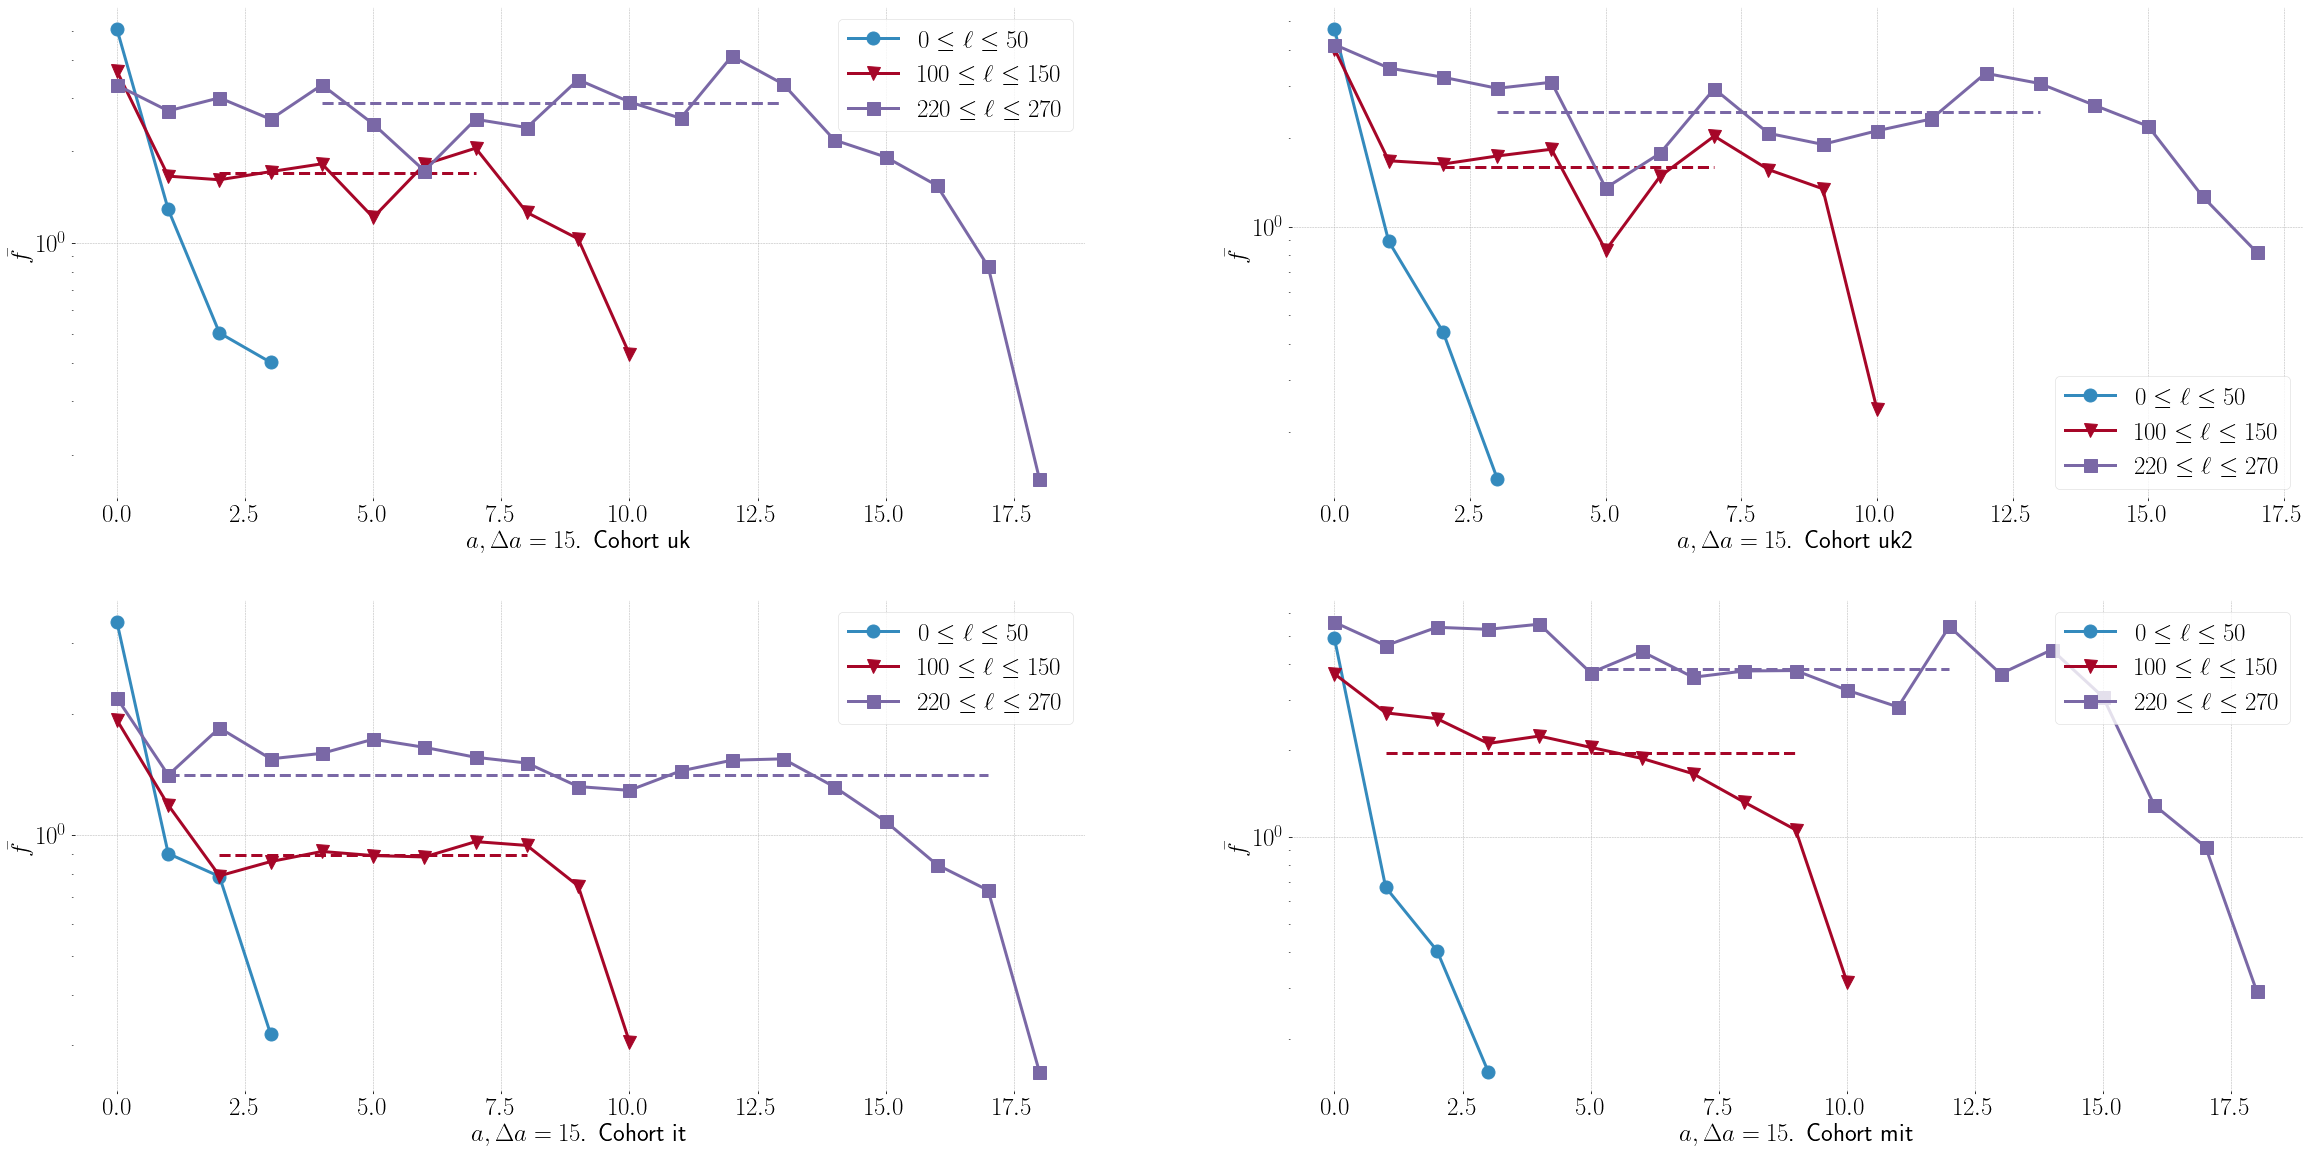

In [278]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    #plt.ylim(10**(-1), 10**1)
    plt.semilogy()
    #plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i].index, fig1[c][i]['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
        if i > 0:
            plt.plot(dashed[c][i][0], dashed[c][i][1], marker="", ls="--", lw=3, c=colors[i])
    plt.legend()
    p += 1
# plt.savefig("/home/vsvh/Desktop/B.png", dpi=200, pad_inches=2)

In [281]:
for c in fig1.keys():
    tmp = pd.DataFrame()
    for l in fig1[c].keys():
        df = fig1[c][l]
        df.columns = [f'l{int(l)}']
        if len(tmp) == 0:
            tmp = tmp.append(df)
        else:
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
    tmp.index.rename('a', inplace=True)
    tmp.fillna('nan', inplace=True)
    #tmp = tmp.loc[tmp.index < 13]
    # tmp.to_csv(f"../commpatterns/PNAS_paper/figs/fig1_{c}.dat", header=True, sep="\t")

In [282]:
tmp

l0        l1        l2
a                               
0   4.899098  3.690011  5.573016
1   0.669597  2.702405  4.624379
2   0.404026  2.579757  5.355678
3   0.153597  2.115821  5.268056
4        nan  2.244728  5.490079
5        nan  2.050972  3.722308
6        nan   1.87763  4.413070
7        nan  1.660857  3.592039
8        nan  1.322691  3.776984
9        nan  1.061077  3.789369
10       nan  0.315278  3.240356
11       nan       nan  2.832562
12       nan       nan  5.391448
13       nan       nan  3.692017
14       nan       nan  4.474868
15       nan       nan  3.065873
16       nan       nan  1.291728
17       nan       nan  0.925435
18       nan       nan  0.291667

# Attempt to scale fig 3

In [ ]:
dff30 = {}
dff30['all'] = {}
for c in calls.keys():
    dff30[c] = pc.get_f(calls[c], 'all', 30, 10)
    dff30['all'].update(dff30[c])
    
dff30['it'] = itdffa30[60]
dff30['all'].update(dff30['it'])

In [ ]:
lives = {}
lives['all'] = {}
for c in ['uk', 'uk2', 'mit']:
    lives[c] = pc.lives_dictionary(calls[c])
    lives['all'].update(lives[c])
lives['it'] = itlives[60]
lives['all'].update(lives['it'])

In [ ]:
survival = {}
for c in dff30.keys():
    survival[c] = pc.get_survival(dff30[c], lambdamax=25)

In [ ]:
t0 = dt.datetime.now()
b = {}
converge = {}
for ell in range(251):
    curve = pc.get_avgfa(dff30['all'], lives['all'], ell, ell + 50)
    if len(curve) > 2:
        points = pc.get_b_slopes(curve, FlagConverge=True)
        b[ell] = points[1][1]
        converge[ell] = points[2]
b = pd.DataFrame.from_dict(b, orient='index').sort_index().rename({0: 'b'}, axis='columns')
tmp = pd.DataFrame.from_dict(converge, orient="index").sort_index().rename({0: 'converge'}, axis='columns')
b = b.merge(tmp, left_index=True, right_index=True, how='outer')
b['ma50'] = b['b'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

In [ ]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
plt.plot(b.index, b['b'], marker="o", markersize=12, ls="dotted", c="black")
plt.plot([x - 25 for x in b.index], b['ma50'], marker="o", markersize=12, ls="dotted", c="red")

In [ ]:
for i in range(6):
    g = 2**(i + 1)
    print(((60 - 30)*g) / 30)

# Rolling window using Italy

and making the distinction between IT1 and IT2

In [2]:
with open('../itdata/tmp/mtl_dffa15.pickle', 'rb') as handle:
    tmpdff = pickle.load(handle)
    handle.close()
    
with open('../itdata/tmp/mtl_livesd.pickle', 'rb') as handle:
    tmplives = pickle.load(handle)
    handle.close()

In [3]:
tmpdff['it'][60].keys()

dict_keys([70, 82, 50, 29, 28, 62, 60, 25, 42, 113, 73, 33, 87, 92, 96, 63, 57, 47, 94, 30, 86, 77, 35, 24, 66, 32, 41, 26, 97, 95, 65, 67, 37, 56, 34, 71, 27, 90, 98, 64, 38, 78, 31, 74, 75, 59, 49, 83, 68, 76, 69, 112, 36, 84, 44, 88, 53, 91, 81, 52, 43, 58, 85, 93, 89, 80, 39, 45, 79, 48, 195, 199, 198, 196, 202, 201, 205, 203, 194, 211, 206, 210, 212, 207, 221, 209, 220, 225, 222, 223, 224, 213, 219, 251, 245, 238, 229, 243, 241, 228, 239, 231, 240, 236, 237, 249, 235, 230, 242, 227, 247, 250, 232, 233, 248, 246, 256, 257, 252, 254, 253, 258, 260, 255, 263, 264, 266, 272, 267, 270, 262, 273, 261, 259, 269, 268, 277, 274, 265, 276, 234, 275, 197])

In [4]:
pikachu = {}
for it in ['it1', 'it2']:
    pikachu[it] = {}
    for ego in tmpdff[it][60].keys():
        thekey = {"it1": "a", "it2": "b"}
        pikachu[it][f'{thekey[it]}{ego}'] = tmpdff[it][60][ego]
        pikachu['it'] = pikachu.get('it', {})
        pikachu['it'][f'{thekey[it]}{ego}'] = {}
        pikachu['it'][f'{thekey[it]}{ego}'].update(tmpdff[it][60][ego])

In [5]:
raichu = {}
for it in ['it1', 'it2']:
    raichu[it] = {}
    for ego in tmplives[it][60].keys():
        thekey = {"it1": "a", "it2": "b"}
        raichu[it][f'{thekey[it]}{ego}'] = tmplives[it][60][ego]
        raichu['it'] = raichu.get('it', {})
        raichu['it'][f'{thekey[it]}{ego}'] = {}
        raichu['it'][f'{thekey[it]}{ego}'].update(tmplives[it][60][ego])

In [6]:
lives = {}
forkey = {'uk1': 'a', 'uk2': 'b'}
for c in ['uk1', 'uk2', 'it1', 'it2', 'mit', 'it', 'uk']:
    if (c == 'it1') or (c == 'it2'):
        lives[c] = raichu[c]
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])
    elif c == 'it':
        lives[c] = raichu[c]
    elif c in ['uk1', 'uk2']:
        lf = pc.lives_dictionary(calls[c])
        for ego in lf.keys():
            for alter in lf[ego].keys():
                ell = lf[ego][alter]['ell']
                if ell > 300:
                    lf[ego][alter]['ell'] = 300
        lives[c] = {}
        for ego in lf.keys():
            thekey = f'{forkey[c]}{ego}'
            lives[c][thekey] = lf[ego]
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])
    elif c == 'uk':
        lives[c] = {}
        for u in ['uk1', 'uk2']:
            lives[c].update(lives[u])
    else:
        lives[c] = pc.lives_dictionary(calls[c])
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])

In [7]:
maxa = {}
for c in calls.keys():
    maxa[c] = max(calls[c]['aclock'])
maxit = 0
for c in ['it', 'it1', 'it2']:
    if c == 'it':
        lvs = itlives[60]
    else:
        lvs = tmplives[c][60]
    for ego in lvs.keys():
        for alter in lvs[ego].keys():
            if lvs[ego][alter]['ell'] > maxit:
                maxit = lvs[ego][alter]['ell']
    maxa[c] = maxit
maxa

{'uk': 482,
 'uk1': 481,
 'uk2': 291,
 'mit': 442,
 'it': 633,
 'it1': 633,
 'it2': 633}

In [13]:
t0 = dt.datetime.now()
b = {}
b2 = {}
nalt = {}
nego = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'it1', 'it2', 'mit']:
    b[c] = {}
    b2[c] = {}
    nalt[c] = {}
    nego[c] = {}
    for ell in range(500):
        if c == 'it':
            tmpres = pc.get_avgfa(pikachu[c], raichu[c], ell, ell + 50, countalt=True)
            curve  = {'f': tmpres[0]}
            tmpn = tmpres[1]
            tmpeg = tmpres[2]
        elif (c == 'it1') or (c == 'it2'):
            tmpres = pc.get_avgfa(pikachu[c], raichu[c], ell, ell + 50, countalt=True)
            curve = {'f': tmpres[0]}
            tmpn = tmpres[1]
            tmpeg = tmpres[2]
        else:
            tmpres = pc.get_avgfa(dffcomb[c], lives[c], ell, ell + 50, countalt=True)
            curve  = {'f': tmpres[0]}
            tmpn = tmpres[1]
            tmpeg = tmpres[2]
        if len(curve['f']) > 2:
            points = pc.get_b_slopes(curve['f'], FlagConverge=True)
            points2 = get_b_mk(curve['f'])
            b[c][ell] = points[1][1]
            b2[c][ell] = points2[1][1]
            nalt[c][ell] = tmpn
            nego[c][ell] = tmpeg
    b[c] = pd.DataFrame.from_dict(b[c], orient='index').sort_index().rename({0: 'slopes'}, axis='columns')
    tmp = pd.DataFrame.from_dict(b2[c], orient="index").sort_index().rename({0: 'mk'}, axis='columns')
    tmp2 = pd.DataFrame.from_dict(nalt[c], orient="index").sort_index().rename({0: 'nalt'}, axis='columns')
    tmp3 = pd.DataFrame.from_dict(nego[c], orient="index").sort_index().rename({0: 'nego'}, axis='columns')
    b[c] = b[c].merge(tmp, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp3, left_index=True, right_index=True, how='outer')
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:16.460398


In [14]:
tmp = pd.DataFrame()
for test in ['mk', 'slopes', 'nalt']:
    abra = pd.DataFrame()
    for c in ['uk1', 'uk2', 'it1', 'it2', 'mit']:
        df = b[c].copy(deep=True)
        df = df[[test]]
        df.columns = [f'{test}{c}']
        abra = abra.merge(df, left_index=True, right_index=True, how='outer')
    abra = abra.loc[abra.index <= 500]
    if test != 'nalt':
        abra[test] = abra.mean(axis=1)
    else:
        abra[test] = abra.sum(axis=1)
    tmp[test] = abra[test]
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S4.0.dat", header=True, index=True, sep="\t")
tmp

KeyError: "None of [Index(['mk'], dtype='object')] are in the [columns]"

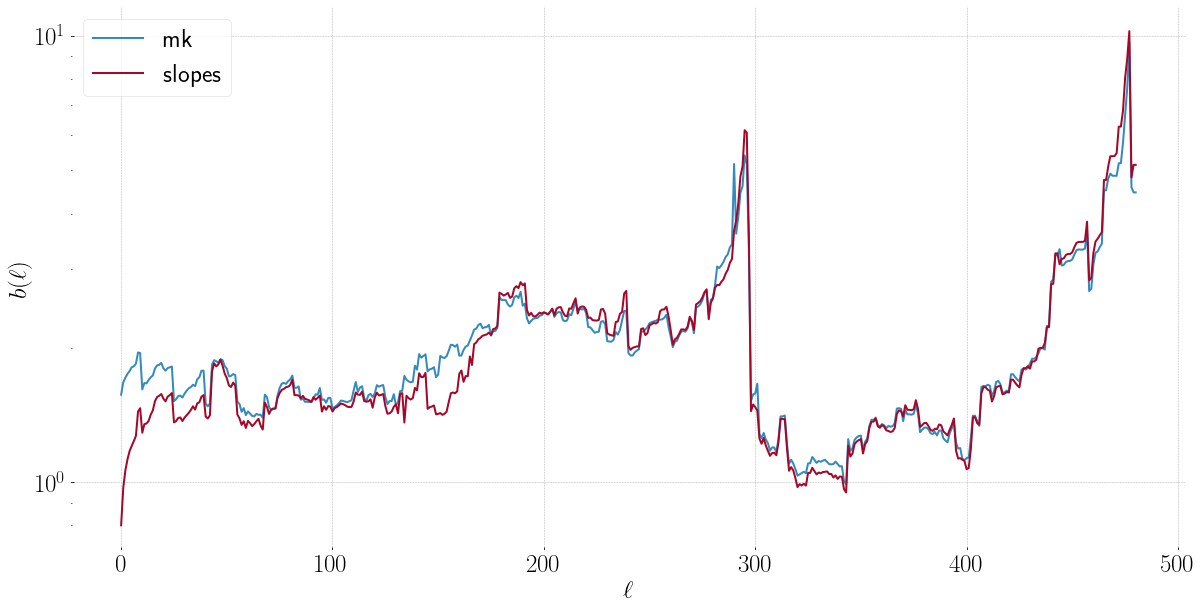

In [96]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$b(\ell)$")
plt.semilogy()
for test in ['mk', 'slopes']:
    plt.plot(tmp.index, tmp[test], label=test)
plt.legend()

In [180]:
# for c in b.keys():
#     df = b[c].copy(deep=True)
#     df.columns = [1,2,3,4]
#     df.index.rename('ell', inplace=True)
#     df.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S4{c}.dat", index=True, header=True, sep="\t")

In [118]:
b.keys()

dict_keys(['uk', 'uk1', 'uk2', 'it', 'it1', 'it2', 'mit'])

In [ ]:
# tmp = pd.DataFrame(index=range(633))
# for c in b.keys():
#     df = b[c].copy(deep=True)
#     if c not in ['uk2', 'it1', 'it2']:
#         df.columns = [f'{c}0', f'{c}1', f'{c}2', f'{c}3']
#     elif c == 'uk2':
#         df.columns = ['ukb0', 'ukb1', 'ukb2', 'ukb3']
#     elif c == 'it1':
#         df.columns = ['ita0', 'ita1', 'ita2', 'ita3']
#     elif c == 'it2':
#         df.columns = ['itb0', 'itb1', 'itb2', 'itb3']
#     tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')

In [ ]:
# tmp.index.rename('a', inplace=True)
# tmp = tmp.fillna('nan')
# tmp.to_csv('../commpatterns/PNAS_paper/SI/figs/S4.dat', header=True, index=True, sep="\t")

In [244]:
b['uk2']

Empty DataFrame
Columns: []
Index: []

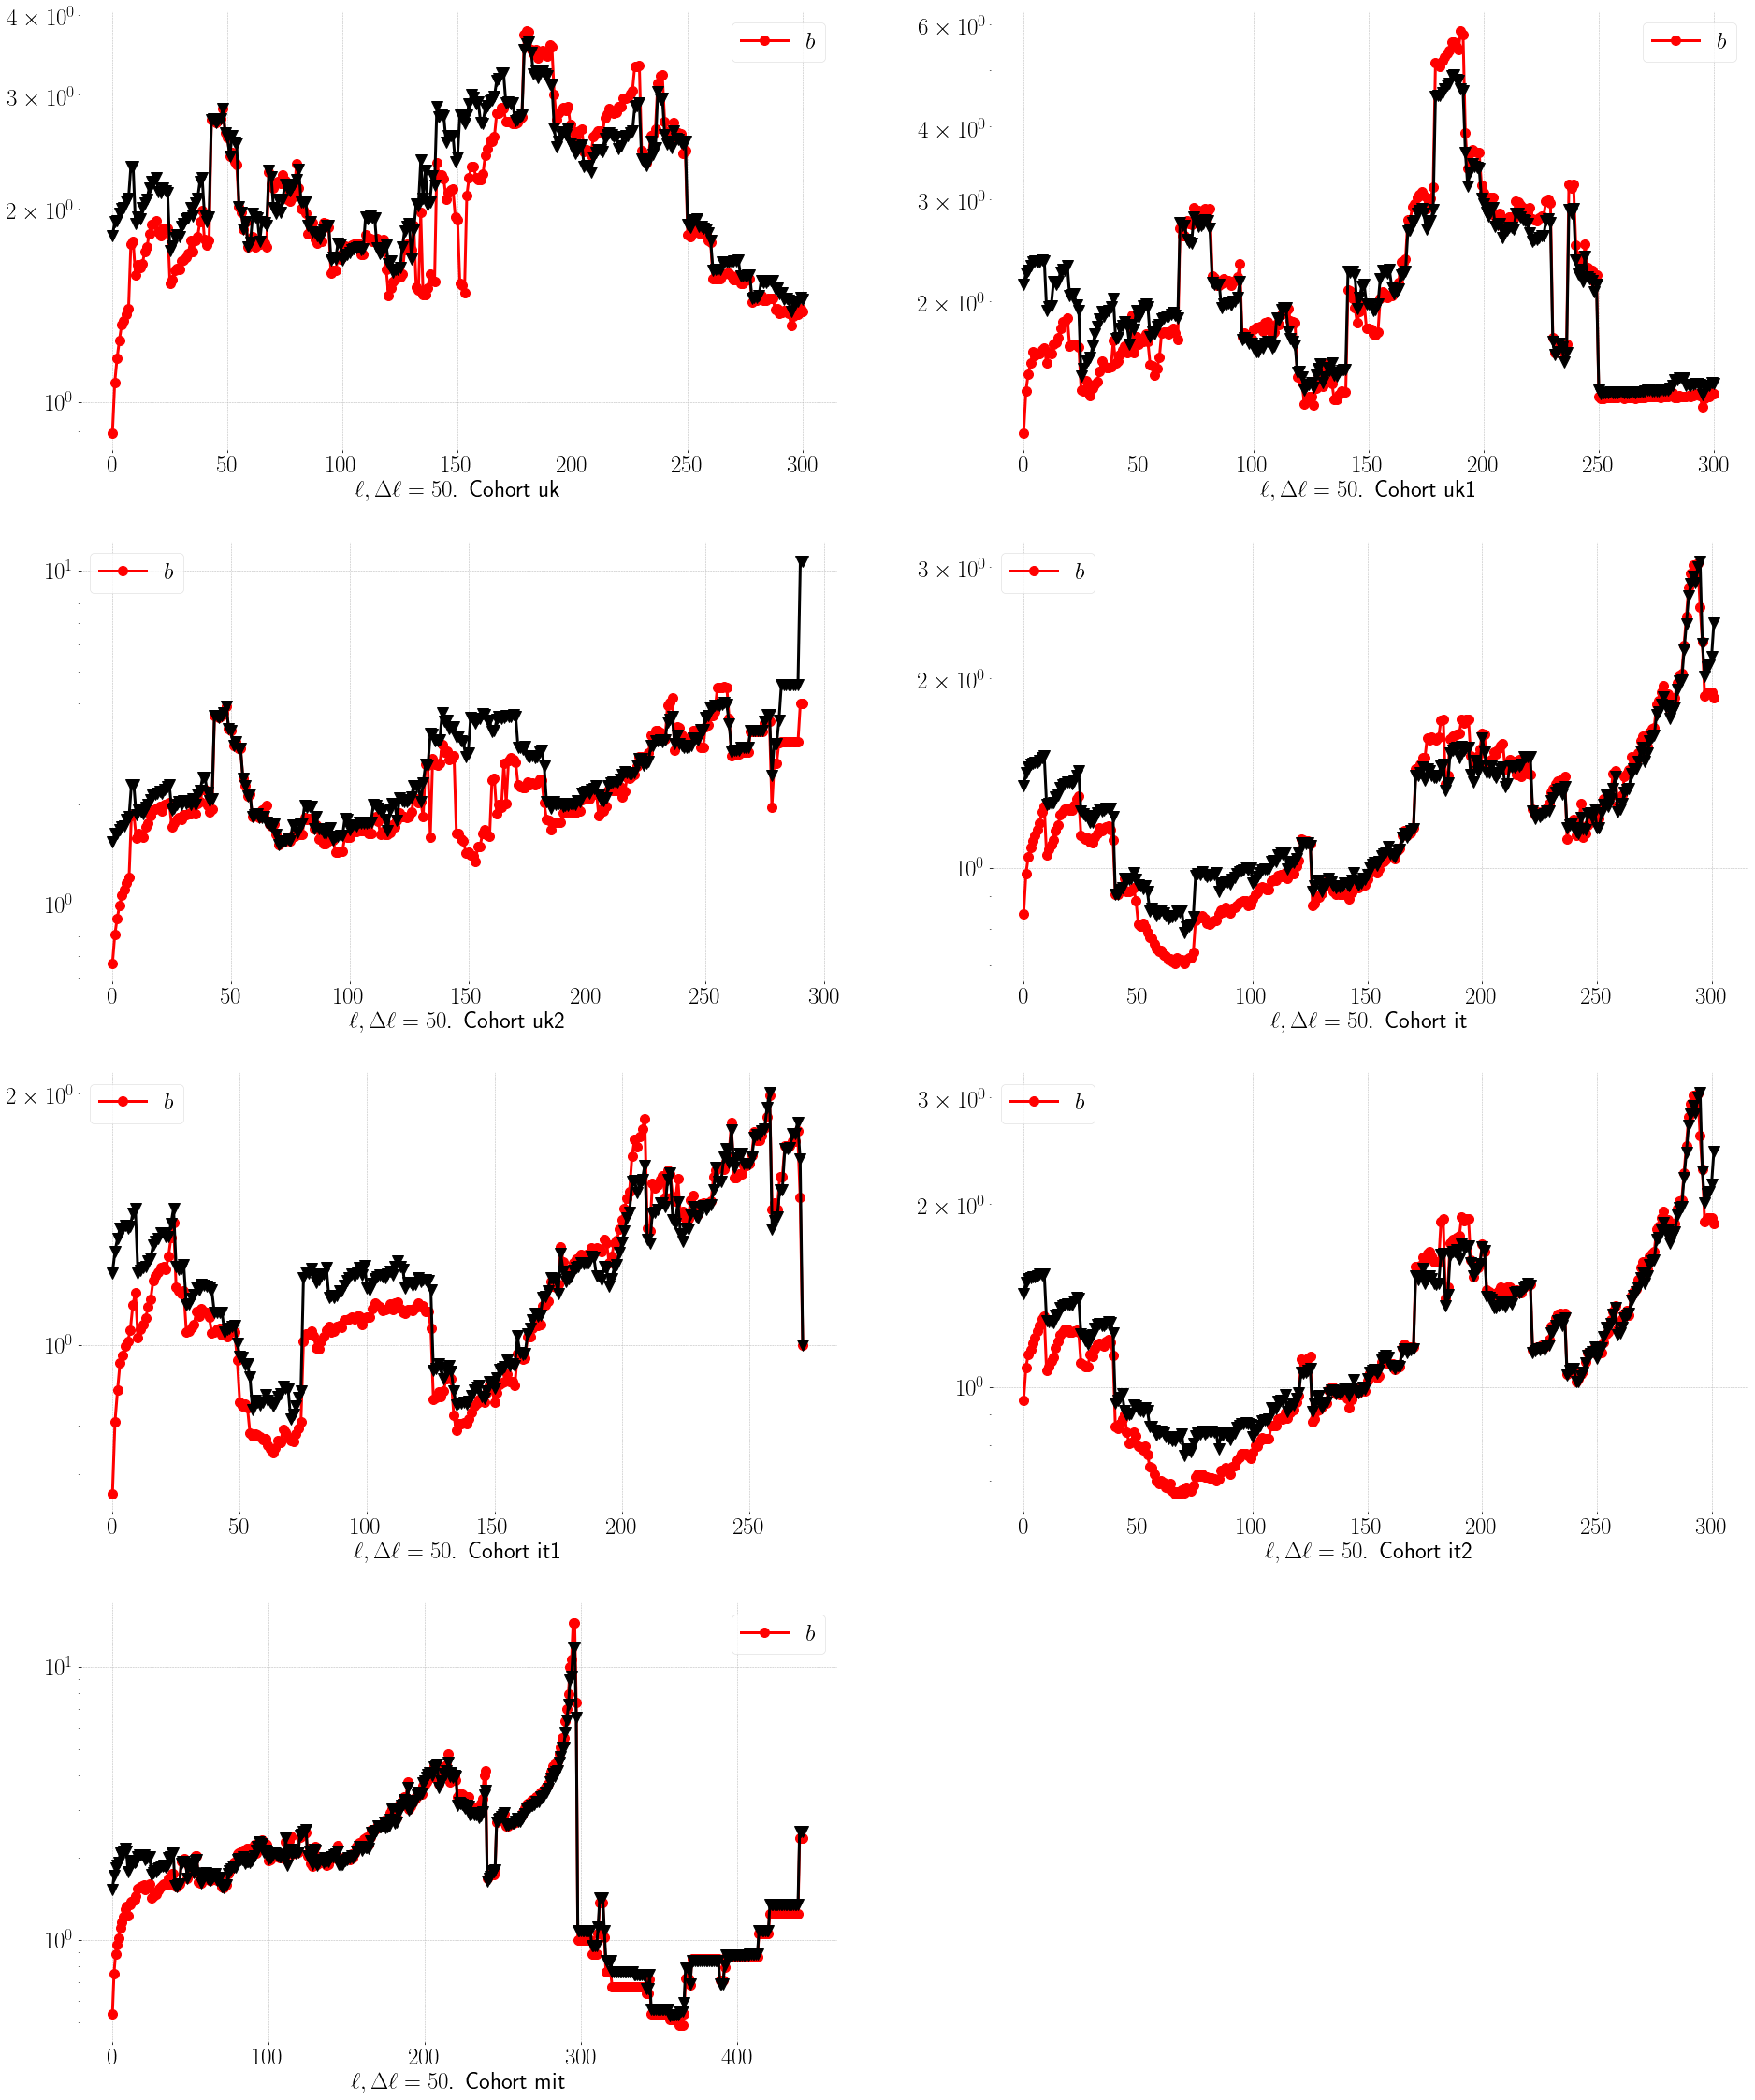

In [259]:
plt.figure(figsize=(16*2, 10*4))
p = 1
for c in b.keys():
    plt.subplot(4,2,p)
    plt.semilogy()
    plt.xlabel(fr'$\ell, \Delta \ell = 50$. Cohort {c}')
    plt.plot(b[c].index, b[c]['slopes'], marker=markers[0], markersize=10, ls="solid", lw=3, c="red", label=r'$b$')
    # plt.plot(b[c].index, b[c]['nalt'], marker=markers[1], markersize=10, ls="solid", lw=3, c="blue", label=r'Number of alters')
    # plt.plot(b[c].index, b[c]['nego'], marker=markers[1], markersize=10, ls="solid", lw=3, c="green", label=r'Number of egos')
    plt.plot(b[c].index, b[c]['mk'], marker=markers[1], markersize=12, ls="solid", lw=3, c="black")
    plt.legend()
    p += 1

In [ ]:
b['it']

In [ ]:
# plt.figure(figsize=(16, 30))
# p = 1
# for c in ['it', 'it1', 'it2']:
#     plt.subplot(3,1,p)
#     plt.xlabel(fr"$\ell, \Delta \ell = 50$. Cohort {c}")
#     plt.ylabel(r'$b$')
#     plt.xlim(-15, 640)
#     plt.ylim(0, 3)
#     plt.plot(b[c].index, b[c]['b'], marker="o", markersize=10, c="black")
#     plt.plot(b[c].index, b[c]['ma50'], marker="o", markersize=10, c="magenta")
#     p += 1

## This is calculate averages of b for all cohorts

In [9]:
lives = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'it1', 'it2', 'mit']:
    if (c == 'it') or (c == 'it1') or (c == 'it2'):
        lives[c] = raichu[c]
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])
    elif c in ['uk', 'uk1', 'uk2']:
        lf = pc.lives_dictionary(calls[c])
        for ego in lf.keys():
            for alter in lf[ego].keys():
                ell = lf[ego][alter]['ell']
                if ell > 300:
                    lf[ego][alter]['ell'] = 300
        lives[c] = lf
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])
    else:
        lives[c] = pc.lives_dictionary(calls[c])
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])

In [10]:
dffcomb = {}
for c in ['it', 'it1', 'it2']:
    dffcomb[c] = pikachu[c]

dffcomb['uk'] = {}
for c in ['uk1', 'uk2']:
    ddf = pc.get_f(calls[c], 'all', 15, 10)
    dffcomb[c] = {}
    forkey = {'uk1': 'a', 'uk2': 'b'}
    for ego in ddf.keys():
        dffcomb[c][f'{forkey[c]}{ego}'] = {}
        for alter in ddf[ego].keys():
            df1 = ddf[ego][alter]
            df2 = df1.loc[(df1['alpha'] <= 20)]
            dffcomb[c][f'{forkey[c]}{ego}'][alter] = df2
            dffcomb['uk'][f'{forkey[c]}{ego}'] = dffcomb['uk'].get(f'{forkey[c]}{ego}', {})
            dffcomb['uk'][f'{forkey[c]}{ego}'][alter] = dffcomb['uk'][f'{forkey[c]}{ego}'].get(alter, df2)
            
dffcomb['mit'] = pc.get_f(calls['mit'], 'all', 15, 10)

In [203]:
t0 = dt.datetime.now()
dffball = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'it1', 'it2', 'mit']:
    if (c == 'it1') or (c == 'it2') or (c == 'it'):
        dfff = pikachu[c]
        dffball.update(dfff)
    else:
        dfff = pc.get_f(calls[c], 'all', 15, 50)
        dffball.update(dfff)
    
        
b = {}
b2 = {}
nalt = {}
nego = {}
c = 'all'
b[c] = {}
b2[c] = {}
nalt[c] = {}
nego[c] = {}
for ell in range(500):
    tmpres = pc.get_avgfa(dffball, lives[c], ell, ell + 50, countalt=True)
    curve  = {'f': tmpres[0]}
    tmpn = tmpres[1]
    tmpeg = tmpres[2]
    if len(curve['f']) > 2:
        points = pc.get_b_slopes(curve['f'], FlagConverge=True)
        points2 = get_b_mk(curve['f'])
        b[c][ell] = points[1][1]
        b2[c][ell] = points2[1][1]
        if c in ['it', 'it1', 'it2']:
            nalt[c][ell] = tmpn
            nego[c][ell] = tmpeg
b[c] = pd.DataFrame.from_dict(b[c], orient='index').sort_index().rename({0: 'slopes'}, axis='columns')
tmp = pd.DataFrame.from_dict(b2[c], orient="index").sort_index().rename({0: 'mk'}, axis='columns')
tmp2 = pd.DataFrame.from_dict(nalt[c], orient="index").sort_index().rename({0: 'nalt'}, axis='columns')
tmp3 = pd.DataFrame.from_dict(nego[c], orient="index").sort_index().rename({0: 'nego'}, axis='columns')
b[c] = b[c].merge(tmp, left_index=True, right_index=True, how='outer')
b[c] = b[c].merge(tmp2, left_index=True, right_index=True, how='outer')
b[c] = b[c].merge(tmp3, left_index=True, right_index=True, how='outer')
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:13.449222


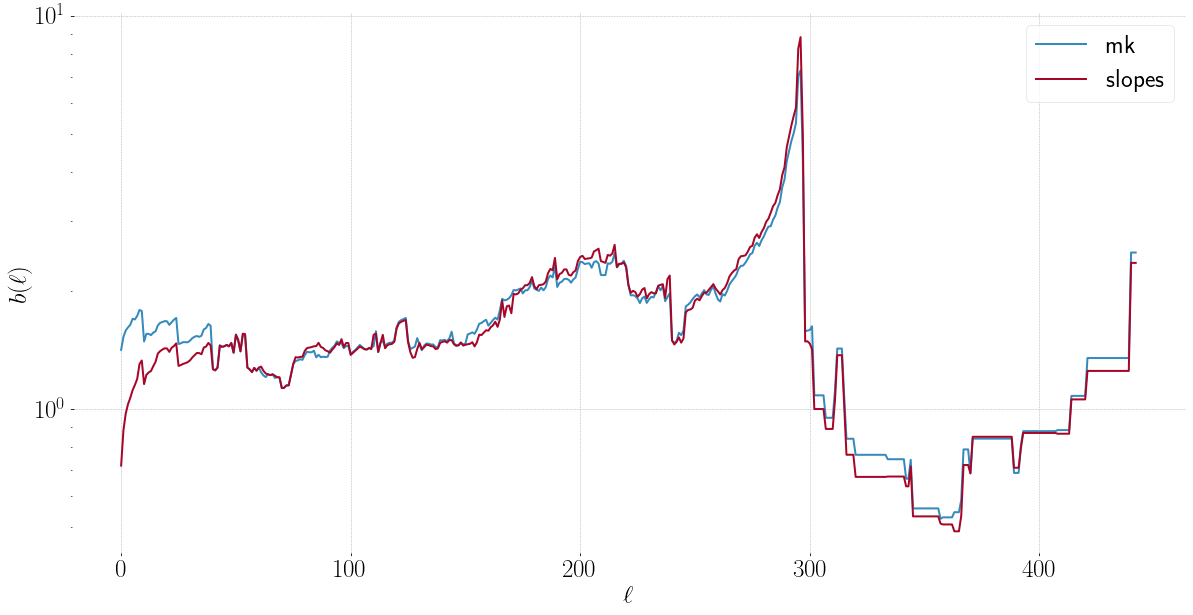

In [191]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$b(\ell)$")
plt.semilogy()
for test in ['mk', 'slopes']:
    plt.plot(b['all'].index, b['all'][test], label=test)
plt.legend()

In [204]:
b['all'].index.rename('ell', inplace = True)
# b['all'].to_csv("../commpatterns/PNAS_paper/SI/figs/S4.1.dat", header=True, index=True, sep="\t")
b['all']['lambda'] = b['all'].index.map(lambda x: x // 50)
b['all']

slopes        mk  lambda
ell                            
0    0.717970  1.414180       0
1    0.882475  1.525070       0
2    0.973866  1.584171       0
3    1.029304  1.613049       0
4    1.067785  1.638229       0
..        ...       ...     ...
438  1.250000  1.347826       8
439  1.250000  1.347826       8
440  2.352941  2.500000       8
441  2.352941  2.500000       8
442  2.352941  2.500000       8

[443 rows x 3 columns]

In [205]:
c = b['all'].groupby('lambda').mean()
c['x'] = c.index.map(lambda x: (x * 50) + 25)
# c.to_csv("../commpatterns/PNAS_paper/SI/figs/S4.2.dat", header=True, index=False, sep="\t")
c

slopes        mk    x
lambda                         
0       1.308623  1.551317   25
1       1.349974  1.331823   75
2       1.468076  1.480426  125
3       1.920565  1.921399  175
4       2.103884  2.049940  225
5       3.046319  2.848491  275
6       0.802951  0.875890  325
7       0.718879  0.730625  375
8       1.171181  1.232578  425

# Fig 1 using only Italy


In [ ]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['it1'] = [(0, 50), (100, 150), (210, 260)]
limits['it2'] = [(0, 50), (160, 210), (290, 340)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

In [ ]:
fig1_it = {}
for c in ['it', 'it1', 'it2']:
    fig1_it[c] = {}
    for i in range(3):
        fig1_it[c][i] = pc.get_avgfa(tmpdff[c][60], tmplives[c][60], limits[c][i][0], limits[c][i][1])

In [ ]:
dashed = {}
for c in ['it', 'it1', 'it2']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1_it[c].keys():
        if lamb >= 0:
#             points = pc.get_plateau(fig1_it[c][lamb], pstar=0.01)
            points = pc.get_b_slopes(fig1_it[c][lamb])
#             dashed[c][lamb] = [[x[0] for x in points], [y[1] for y in points]]
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

In [ ]:
plt.figure(figsize=(16, 30))
p = 1
for c in fig1_it.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    plt.semilogy()
    plt.xlim(-5, 375)
    plt.ylim(0.1, 10)
    for i in range(3):
        plt.plot([x * 15 for x in fig1_it[c][i].index], fig1_it[c][i]['f'], marker=markers[i], markersize=10, ls="solid", lw=2, c=colors[i], label=fr'${limits[c][i][0]} \leq \ell \leq {limits[c][i][1]}$')
        if i > 0:
            plt.plot([x * 15 for x in dashed[c][i][0]], dashed[c][i][1], marker="", ls="--", lw=4, c=colors[i])
    plt.legend()
    p += 1

# Quick result for proportion of lives and calls

For each series in Fig 1 (main paper); I have to count how many alters and how many phone calls out of the total we have **used** for the analysis

In [ ]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

In [ ]:
lives = {}
for c in ['uk', 'uk2', 'mit']:
    lives[c] = pc.lives_dictionary(calls[c])
    
lives['it'] = itlives[60]

In [ ]:
counts = {}
for c in ['uk', 'uk2', 'mit', 'it']:
    counts[c] = {}
    for i in range(1, 21):
        alters = 0
        ncalls = 0
        a = 0
        cc = 0
        for ego in lives[c].keys():
            for alter in lives[c][ego].keys():
                vol = lives[c][ego][alter]['nij']
                if vol > i:
                    alters += 1
                    ncalls += vol
                    ell = lives[c][ego][alter]['ell']
                    if (ell >= limits[c][0][0] and ell <= limits[c][0][1]) or (ell >= limits[c][1][0] and ell <= limits[c][1][1]) or (ell >= limits[c][2][0] and ell <= limits[c][2][1]):
                        a += 1
                        cc += vol
            counts[c][i] = (a / alters, cc / ncalls)
    counts[c] = pd.DataFrame({'alters': [counts[c][i][0] for i in range(1, 21)], 'calls': [counts[c][i][1] for i in range(1, 21)]}, index=range(1, 21))

In [ ]:
plt.figure(figsize=(12*2, 8*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel("Minimal volume of calls")
    plt.ylabel(f"Proportion in cohort {c}")
    plt.ylim(0.1, 1)
    plt.semilogy()
    plt.plot(counts[c].index, counts[c]['alters'], marker=markers[0], markersize=13, ls="--", label="Alters")
    plt.plot(counts[c].index, counts[c]['calls'], marker=markers[0], markersize=13, ls="--", label="Calls")
    plt.legend()
    p += 1

In [ ]:
tmp = {}
for c in ['uk', 'uk2', 'mit']:
    tmp[c] = pc.lives_dictionary(unfiltered[c])
    
counts = {}
for c in ['uk', 'uk2', 'mit']:
    alters = 0
    ncalls = 0
    a = 0
    cc = 0
    counts[c] = {}
    for i in range(10, 301, 10):
        tmpc = pc.apply_filters(unfiltered[c], i)
        tmpl = pc.lives_dictionary(tmpc)
        for ego in tmp[c].keys():
            for alter in tmp[c][ego].keys():
                vol = tmp[c][ego][alter]['nij']
                alters += 1
                ncalls += vol
                if (ego in tmpl.keys()) and (alter in tmpl[ego].keys()):
                    a += 1
                    cc += vol
            counts[c][i] = (a / alters, cc / ncalls)
    counts[c] = pd.DataFrame({'alters': [counts[c][i][0] for i in range(10, 301, 10)], 'calls': [counts[c][i][1] for i in range(10, 301, 10)]}, index=range(10, 301, 10))

In [ ]:
plt.figure(figsize=(12, 8*3))
p = 1
for c in ['uk', 'uk2', 'mit']:
    plt.subplot(3, 1, p)
    plt.xlabel(fr"$\Delta t_w$")
    plt.ylabel(f"Proportion in cohort {c}")
    plt.ylim(0.1, 1)
    plt.semilogy()
    plt.plot(counts[c].index, counts[c]['alters'], marker=markers[0], markersize=13, ls="--", label="Alters")
    plt.plot(counts[c].index, counts[c]['calls'], marker=markers[0], markersize=13, ls="--", label="Calls")
    plt.legend()
    p += 1

In [ ]:
counts['uk']

# Change $\gamma$ in Fig 3

In [ ]:
survival4 = {}
for c in dff30.keys():
    survival4[c] = pc.get_survival(dff30[c], lambdamax=25, base=4)

In [ ]:
plt.figure(figsize=(20*2, 10*2))
plt.subplot(2,2,1)
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(4):
    plt.plot(survival4['all'][i].index, survival4['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${4**i} \leq g < {4**(i + 1)}$')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(6):
    plt.plot(survival['all'][i].index, survival['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(1, 4):
    plt.plot(survival4['all'][i].index, survival4['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${4**i} \leq g < {4**(i + 1)}$')
plt.legend()

plt.subplot(2,2,4)
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(1, 6):
    plt.plot(survival['all'][i].index, survival['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
plt.legend()